In [668]:
import os 
os.chdir('/home/lucasperea/Documents/GraphMaterials/')
import networkx as nx
from pymatgen.core.structure import Structure
from GraphFunc.ZeoDataframeFunction import ZeoDataframe
from GraphFunc.ConexionFunction import Conexion
from pymatgen.io.cif import CifWriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from networkx.relabel import relabel_nodes
from pymatgen.core.structure import Structure
import math
import itertools
from itertools import combinations, combinations_with_replacement
from math import pi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [527]:
x_1

[(30, 29, 0.0922282),
 (33, 32, 0.0922282),
 (49, 28, 1.39808),
 (50, 24, 1.10205),
 (55, 20, 0.78061),
 (65, 59, 1.10205),
 (66, 63, 0.78061),
 (67, 67, 0.429155),
 (68, 68, 0.759739),
 (69, 69, 0.429155)]

In [675]:
mat_dic = {}
path_dic = {}
i = 0
for cif_name in os.listdir('./CifFiles/')[:]:
    

    letter_name = cif_name.split('.')[0]

    path_nt2 = './Nt2Files/' + letter_name + '.nt2'
    stu = Structure.from_file('./CifFiles/' + letter_name + '.cif')

    # Here, we have the lattice vector of the structure we want to apply PageRank algorithm
    # We will use the point of applicattion of the lattice vector of the cell to locate them in space 
    # once we put multiple cells togehter


    # We take coodinates of the vectors A, B and C
    stu.lattice

    # Dimensions of the cell
    box = np.array([stu.lattice.abc[0], stu.lattice.abc[1], stu.lattice.abc[2]])

    # Angles of the cell's axis
    alpha = stu.lattice.alpha
    beta = stu.lattice.beta
    gamma = stu.lattice.gamma

    # Constant to change from degrees to radians
    cte = math.pi/180

    # Vectors proyections of the cell's vector over the ortogonal axis
    x_axis = stu.lattice.a
    y_axis = stu.lattice.b
    z_axis = stu.lattice.c

    # Cell's vectors
    a, b, c = round(x_axis*math.sin(beta*cte), 3) , 0 ,round(x_axis*math.cos(beta*cte), 3)
    d, e, g = round(y_axis*math.cos(gamma*cte), 3) ,round(y_axis*math.sin(gamma*cte), 3), 0
    l, m, n = 0, round(z_axis*math.cos(alpha*cte), 3), round(z_axis*math.sin(alpha*cte), 3)

    # Constant that limits the maximum number of cells that could expand over every direction 
    # (axis and diagonal direction)
    r = 1

    cubic_comb = []

    # Each of the cell's vectors represent the length of the cell in that direction.
    # Independently of which length it is if you multiply the length of one of the vector by two it is clear
    # that the result vector will give the information about the location of the second cell in the direction
    # of the vector we multiply by two.

    # We generate the location of the cells for a cube of length equals to len(range(-r, r + 1))
    # r = 1, len(range(-r, r + 1)) = 27
    # The information of location of the cells are saved in real coordinates using the combination of the 
    # cell's vectors and in an orthogonal base transformation using as vectors the numbers (i,j,k) we use to multiply 
    # the cell's vectors
    for i in range(-r, r+1):
        for j in range(-r, r+1):
            for k in range(-r, r+1):
                cubic_comb.append((np.array([a,b,c])*i + np.array([d,e,g])*j + np.array([l,m,n])*k,
                                   np.array([i,j,k])))



    vector_pos = []
    vector_ort = []
    # Unpack values
    # We also choose as a center the vector 0 
    lattice_vector = stu.lattice
    #     print('This is the Lattice vector: {}'.format(lattice_vector.abc))

    for vec, ort in cubic_comb:
        vector_pos.append(list(vec))
        vector_ort.append(list(ort))

    # Later in this Notebook we are going to create a graph for every vector we generated in the previous step.
    # These graphs will be composed by nodes whose names will be an ordered number.
    # The names will be assigned by the order the graphs were generated.
    # That means every graph will have as the name of their nodes a range of numbers whose length will be equal 
    # to the name of the last node we create in the first graph.
    # In order to keep track of the order we create we are going to establish that order by numbered the orthogonal
    # vectors

    pos_order = {}
    i = 0
    for vector in vector_ort:
        name = str(vector[0]) + str(vector[1]) + str(vector[2]) 
        pos_order[name] = i
        i += 1


    six_faces_neigh = [np.array([1,0,0]), np.array([-1, 0,0]), np.array([0,1,0]), 
              np.array([0,-1,0]), np.array([0,0,1]), np.array([0,0,-1])]

    # Initialize a networkx's graph. 
    # We take the information about the nodes and edges from the .nt2 file and passes it out to the graph.

    # Every node in the graph will have three attributes.
    # -Cartesian coordinate
    # -Pagerank coefficient
    # -Radius of the maximus sphere that fit in that node

    # Evey edge will have one attribute:
    # -Radius of the maximus sphere that can travel through the edge

    # We are not going to save the information about edges that connect point from outside of the cell

    G = nx.Graph()

    pagerank_init_value = 100
    with open(path_nt2) as f:
        line = ' '

        while line:
            line = f.readline()

            if line == 'Vertex table:\n': 

                while line:

                    line = f.readline()

                    if line == '\n':
                        break
                    else:
                        line_list = line.split()
                        key = int(line_list[0])
                        coord_x = float(line_list[1])
                        coord_y = float(line_list[2])
                        coord_z = float(line_list[3])
                        min_dist_atom = float(line_list[4])

                        G.add_node(key, coord=np.array([coord_x, coord_y, coord_z]), rad_max_sph=min_dist_atom,
                                  pagerank=pagerank_init_value)

        #                 vertex_table = vertex_table.append({'coord_x':coord_x, 'coord_y':coord_y, 'coord_z':coord_z,
        #                                                     'min_dist_atom':min_dist_atom, 'key':key},ignore_index = True)


    #         x_1 = len(list(range(0,(sorted(list(G.nodes), reverse=True)[0] + 1))))



            if line == 'Edge table:\n':


                while line:

                    line = f.readline()
                    if line == '':
                        break
                    line_list = line.split()
                    origin = int(line_list[0])
                    destination = int(line_list[2])
                    larger_radius = float(line_list[3])
                    x_sim = int(line_list[4])
                    y_sim = int(line_list[5])
                    z_sim = int(line_list[6])
    #                 if x_sim == 8:
    #                     G.add_node(destination + x_1, coord=G.nodes[destination]['coord'] + np.array([box[0], 0, 0]),
    #                                rad_max_sph=G.nodes[destination]['rad_max_sph'], pagerank=pagerank_init_value)

    #                     G.add_edge(origin, destination + x_1, rad_max_sph=larger_radius)
    #                     print(destination + x_1)
    #                 else:
                    if sum([abs(x_sim), abs(y_sim), abs(z_sim)]) == 0:
                        G.add_edge(origin, destination, rad_max_sph=larger_radius)

                    else:
                        pass

    #     print( sorted(G.nodes)[-1])
    total_nodes_G = len(G.nodes)
    larger_dist_atom = []
    for i in G.nodes:
        larger_dist_atom.append(G.nodes[i]['rad_max_sph'])

    larger_node = max(larger_dist_atom)
    index_larger_node = np.argmax(larger_dist_atom)
    name_larger_node = list(G.nodes)[index_larger_node]

    # We didn't save the connection between nodes of different cells before  we are going to save it right now 
    # but in a dictionary
    # The information will be stored in six lists since the cell has six faces. In each list will contains the
    # connections between the nodes that go through that specific face.

    conx_cell = {}
    x_1 = []
    x_minus_1 = []
    y_1 = []
    y_minus_1 = []
    z_1 = []
    z_minus_1 = []
    with open(path_nt2) as f:
        line = ' '

        while line:
            line = f.readline()

            if line == 'Edge table:\n':
                while line:

                    line = f.readline()

                    if line == '':
                        break

                    line_list = line.split()
                    origin = int(line_list[0])
                    destination = int(line_list[2])
                    larger_radius = float(line_list[3])
                    x_sim = int(line_list[4])
                    y_sim = int(line_list[5])
                    z_sim = int(line_list[6])
                    if sum([abs(x_sim), abs(y_sim), abs(z_sim)]) == 0:
                        pass
                    else:
                        if x_sim == 1:
                            x_1.append((origin,destination,larger_radius))

    #                             print(origin,destination)
                        elif x_sim == -1:
                             x_minus_1.append((origin,destination,larger_radius))
                        elif y_sim == 1:
                             y_1.append((origin,destination,larger_radius))
                        elif y_sim == -1:
                             y_minus_1.append((origin,destination,larger_radius))
                        elif z_sim == 1:
                             z_1.append((origin,destination,larger_radius))
                        elif z_sim == -1:
                             z_minus_1.append((origin,destination,larger_radius))
                        else:
                            print('outside of one cell radius')



    conx_cell['100'] = x_1
    conx_cell['-100'] = x_minus_1
    conx_cell['010'] = y_1
    conx_cell['0-10'] = y_minus_1
    conx_cell['001'] = z_1
    conx_cell['00-1'] = z_minus_1

    # Create a dictionary which contains one graph for every cell we want to use to calculate the 
    # pagerank coefficients. 
    # These new graphs are a copy of the one that we initialized in previous step so, we 
    # change the names and the cartesian coordinates for every node

    graph_mod= {}

    # As we mentioned earlier we are goint to name the nodes wit a number.
    # The name of the last node of the first graph plus one (because we start in 0) will give as the range in every 
    # graph.

    key_plus = sorted(list(G.nodes), reverse=True)[0] + 1

    # The names used as keys in the dictionary of graph are the ortogonal base transformations we calculated before
    # They names are very useful to know the position of the graph with respect to the origin (0,0,0).

    for i in range(len(vector_pos)):
        name = str(vector_ort[i][0])+str(vector_ort[i][1])+str(vector_ort[i][2])
        graph_mod[name] = deepcopy(G)

        mapping_name = {}
        multiplier = pos_order[name]
        for node in graph_mod[name].nodes:
            graph_mod[name].nodes[node]['coord'] += vector_pos[i] #*box
            mapping_name[node] = node + key_plus*multiplier
        relabel_nodes(graph_mod[name], mapping=mapping_name, copy=False)

    # As you can see here it is really to see where the graph is if we now their name
    #     print('Keys of the Dictionary of Graph: {}'.format(graph_mod.keys()))


    # List with the names of the graph
    cell_list = list(graph_mod.keys())

    # Now we add to the graph the edges that connect with nodes outside of the cell. We do this for every graph 
    # in the dictionary

    for j in range(len(vector_pos)):
        for neighbor in six_faces_neigh:
            str_neighbor = str(neighbor[0]) + str(neighbor[1]) + str(neighbor[2]) 

            neig_loc = vector_ort[j] + neighbor
            str_neig_loc = str(neig_loc[0])+str(neig_loc[1])+str(neig_loc[2])

            if str_neig_loc in cell_list:
                name = str(vector_ort[j][0])+str(vector_ort[j][1])+str(vector_ort[j][2])
                multiplier_origin = pos_order[name]
                multiplier_destination = pos_order[str_neig_loc]

                for edge in conx_cell[str_neighbor]:
                    edge_1 = edge[0] + multiplier_origin*key_plus
                    edge_2 = edge[1] + multiplier_destination*key_plus
                    rad_max_sph = edge[2]
                    graph_mod[name].add_edge(edge_1, edge_2)
                    graph_mod[name].edges[edge_1, edge_2]['rad_max_sph'] = rad_max_sph


    x_list = []
    x_minus_list = []
    y_list = []
    y_minus_list = []
    z_list = []
    z_minus_list = []

    allcells = list(graph_mod.keys())

    for i in range(-r, r+1):
        for j in range(-r, r+1):
            for k in range(-r, r+1):
                if abs(i) == r:
                    if i == r:
                        x_list.append(str(i)+str(j)+str(k))
                    else:
                        x_minus_list.append(str(i)+str(j)+str(k))
                if abs(j) == r:
                    if j == r:
                        y_list.append(str(i)+str(j)+str(k))
                    else:
                        y_minus_list.append(str(i)+str(j)+str(k))
                if abs(k) == r:
                    if k == r:
                        z_list.append(str(i)+str(j)+str(k))
                    else:
                        z_minus_list.append(str(i)+str(j)+str(k))

    for k in range(len(x_list)):
        name_origin_x = x_list[k]
        name_destination_x = x_minus_list[k]

        name_origin_y = y_list[k]
        name_destination_y = y_minus_list[k]

        name_origin_z = z_list[k]
        name_destination_z = z_minus_list[k]

        multiplier_origin_x = pos_order[name_origin_x]
        multiplier_destination_x = pos_order[name_destination_x]

        multiplier_origin_y = pos_order[name_origin_y]
        multiplier_destination_y = pos_order[name_destination_y]

        multiplier_origin_z = pos_order[name_origin_z]
        multiplier_destination_z = pos_order[name_destination_z]

        for edge in conx_cell['100']:
            edge_1 = edge[0] + multiplier_origin_x*key_plus
            edge_2 = edge[1] + multiplier_destination_x*key_plus
            rad_max_sph = edge[2]
            graph_mod[name_origin_x].add_edge(edge_1, edge_2)
            graph_mod[name_origin_x].edges[edge_1, edge_2]['rad_max_sph'] = rad_max_sph

    #         print(name_origin_x, name_destination_x)
    #         print(edge_1, edge_2)
    #         print(edge[0], edge[1])
    #         print('_____________')

        for edge in conx_cell['010']:
            edge_1 = edge[0] + multiplier_origin_y*key_plus
            edge_2 = edge[1] + multiplier_destination_y*key_plus
            rad_max_sph = edge[2]
            graph_mod[name_origin_y].add_edge(edge_1, edge_2)
            graph_mod[name_origin_y].edges[edge_1, edge_2]['rad_max_sph'] = rad_max_sph

        for edge in conx_cell['001']:
            edge_1 = edge[0] + multiplier_origin_z*key_plus
            edge_2 = edge[1] + multiplier_destination_z*key_plus
            rad_max_sph = edge[2]
            graph_mod[name_origin_z].add_edge(edge_1, edge_2)
            graph_mod[name_origin_z].edges[edge_1, edge_2]['rad_max_sph'] = rad_max_sph


    # Here, we create a final graph and we store in it the information of all the nodes and edges of the ones
    # we generate in the previous step
    final = nx.Graph()

    for key in graph_mod:
        final.add_nodes_from(graph_mod[key])
        final.add_edges_from(graph_mod[key].edges)
        for node in graph_mod[key].nodes:
            for attr in graph_mod[key].nodes[node]:
                final.nodes[node][attr] = graph_mod[key].nodes[node][attr]

        for edge in graph_mod[key].edges:
            for attr in graph_mod[key].edges[edge[0], edge[1]]:
                final.edges[edge][attr] = graph_mod[key].edges[edge][attr] 


    # We calculate the neighbors for every node in the graph
    neigh_dic = {}
    for n, nbrs in final.adj.items():
        neigh = []
        for nbr, eattr in nbrs.items():
            neigh.append(nbr)


        neigh_dic[str(n)] = neigh


    # For every node we calculate the sum of the square radius of their edges
    sum_radius = {}
    for node in final.nodes:

        sum_edges = 0
        for nei in neigh_dic[str(node)]:

            score = final[node][nei]['rad_max_sph']
            sum_edges += score**2
        sum_radius[str(node)] = sum_edges

    #  conexion is a dictionary that saves information of the weights that every edge has in 
    # relationship with the total number of edges in the node.
    # Every edge has a radius as attribute so we are using the proportion of the square of the radius divide by
    # the sum of the square radius in the node

    conexion = {}
    sub = {}
    for node in final.nodes:

        sub = {}
        for nei in neigh_dic[str(node)]:
            radius_node = final[node][nei]['rad_max_sph']
            all_radius = sum_radius[str(nei)] 
            sub[str(nei)] = radius_node**2/all_radius
        conexion[str(node)] = sub


    def unit_sum(pagerank_list):
        return pagerank_list/sum(pagerank_list)

    # Loop over the number of iterations we want to run pagerank
    def pagerank(graph, iteration, conexion, neigh_dic):
        node_list = sorted(list(graph.nodes))
        for i in range(iteration):
            pagerank_list = pagerank_one_iter(graph, conexion, neigh_dic, node_list)
        return pagerank_list

    # Loop over the nodes of the graph
    def pagerank_one_iter(graph, conexion, neigh_dic, node_list):
        for selfnode in node_list:
            update_pagerank(selfnode, conexion, neigh_dic, graph)
        pagerank_list = np.asarray([graph.nodes[node]['pagerank'] for node in node_list], dtype='float32')
        return pagerank_list

    # Update of the nodes attribute pagerank following the rule we describe in connections
    def update_pagerank(selfnode, conexion, neigh_dic, graph):
        in_neighbors = neigh_dic[str(selfnode)] #self.parents
        pagerank_sum = sum(graph.nodes[node]['pagerank']*conexion[str(selfnode)][str(node)]
                           for node in in_neighbors)
        graph.nodes[selfnode]['pagerank'] = pagerank_sum


    info = pagerank(final, 50, conexion, neigh_dic)

    most_connected_all = list(final.nodes)[np.argmax(info)]
    most_connected_all_value = info[np.argmax(info)]

    #     print(list(G.nodes)[-1] + 1, names_nodes_center_cell[-1])
    names_nodes_center_cell = list(np.array(G.nodes) + key_plus*pos_order['000'])



    pgrk_nodes = []

    for node in names_nodes_center_cell:
        pgrk_nodes.append((node, final.nodes[node]['pagerank']))

    last = 0
    for node, pgrk in pgrk_nodes:

        if pgrk > last:
            max_pr = (node, pgrk)
            last = pgrk
        else:
            pass



    #     index_center_cell = []


    #     for i in range(len(final.nodes)):
    #         if list(final.nodes)[i] in names_nodes_center_cell:
    #             index_center_cell.append(i)
    #         else:
    #             pass
    #     index_most_connected = np.argmax(info[index_center_cell])

    most_connected_node_cell = max_pr[0]-pos_order['000']*key_plus
    most_connected_node_cell_value = max_pr[1]

    mat_dic[letter_name] = {'LargerNode':larger_node, 'IndexLN':name_larger_node, 
                     'MostConnectedNodeCell':most_connected_node_cell, 
                            'RadiusMCNC':final.nodes[most_connected_node_cell]['rad_max_sph'],
                            'MostConnectedNodeCellValue':most_connected_node_cell_value,
                     'MostConnectedAll':most_connected_all, 'RadiusMCNA':final.nodes[most_connected_all]['rad_max_sph'],
                     'MostConnectedAllValue':most_connected_all_value}


    dim = 3

    # Matrix to change the orthogonal base vector to the base vector of the unit cell

    A = np.array([[a,b,c],[d,e,g], [l,m,n]]).transpose()
    B1 = np.array([1, 0, 0])
    B2 = np.array([0, 1, 0])
    B3 = np.array([0, 0, 1])
    X = np.array([np.linalg.inv(A).dot(B1),np.linalg.inv(A).dot(B2),np.linalg.inv(A).dot(B3)])
    Y = X.transpose()

    # Matrix to change the base vector of the unit cell for the orthogonal base vector
    A1 = np.array([[1,0,0], [0,1,0], [0,0,1]]).transpose()
    B4 = np.array([a,b,c])#*3
    B5 = np.array([d,e,g])#*3
    B6 = np.array([l,m,n])#*3
    X1 = np.array([np.linalg.inv(A1).dot(B4),np.linalg.inv(A1).dot(B5),np.linalg.inv(A1).dot(B6)])
    Y1 = X1.transpose()

    # Function for the calculation of distances between axes
    def distance(final, node1, node2, multi_box, Y, Y1):

        dim = 3

        real_box = np.array([multi_box,multi_box,multi_box])

        p1 = Y.dot(final.nodes[node1]['coord'])
        p2 = Y.dot(final.nodes[node2]['coord'])
    #     print(p1, p2)
        dist_3d = np.zeros((dim))
        for j in range(dim):
            dist = abs(p2[j]-p1[j])
            if dist > real_box[j] * 0.5:
                dist = abs(real_box[j] - dist)
            dist_3d[j] = dist
        return np.sqrt(np.sum(np.power(Y1.dot(dist_3d), 2)))

    for edge in final.edges:
        final[edge[0]][edge[1]]['distance'] = distance(final, edge[0], edge[1], 3, Y, Y1)


    from queue import PriorityQueue
    def dijkstra(start_vertex, target, parents, final):

        # Dictionary with keys = vertices and values = weights of the vertices (set as infinity at the start)
        D = {}
        visited = []
        node_list = list(final.nodes)

        D = {v:float('inf') for v in node_list}
        D[start_vertex] = 0

        pq = PriorityQueue()
        pq.put((0, start_vertex))

        while not pq.empty():
            (dist, current_vertex) = pq.get()
            if current_vertex == target:
                print('Target vertex: ' + str(target) + ' reached')
                break
            else:

                visited.append(current_vertex)


                # Loop for every vertex of the net
                for neighbor in neigh_dic[str(current_vertex)]:
    #                         if self.edges[current_vertex][neighbor] != -1:
                    distance = final[current_vertex][neighbor]['distance']

                    if neighbor not in visited:
                        old_cost = D[neighbor]
                        new_cost = D[current_vertex] + distance
                        if new_cost < old_cost:
                            pq.put((new_cost, neighbor))
                            D[neighbor] = new_cost
                            parents[neighbor] = current_vertex

        return D, parents

    def backpedal(start_vertex, target, searchResult):

        node = target

        backpath = [node]

        path = []

        while node != start_vertex:

            backpath.append(searchResult[node])

            node = searchResult[node]

        for i in range(len(backpath)):

            path.append(backpath[-i - 1])

        return path 



    all_path = []
    total_path = []
    special_list = list(range(13))

    node_path = most_connected_node_cell

    for location in special_list:
        parents = {}

        start = node_path + key_plus*location

        target = key_plus*pos_order['000'] + node_path

        D, P = dijkstra(start, target, parents, final)

        path = backpedal(start, target, P)

        distance_path = []
        for i in range(len(path)-1):

            distance_path.append(final[path[i]][path[i+1]]['distance'])


        all_path.append(path)
        total_path.append(sum(distance_path))  


    total_vol = []
    for ind_path in all_path:
        volume = []
        for i in range(len(ind_path) - 1):
            volume.append(
                final[ind_path[i]][ind_path[i+1]]['distance']*(final[ind_path[i]][ind_path[i+1]]['rad_max_sph']**2)*pi)
        total_vol.append(sum(volume))

    path_dic_mat = {}

    for j in range(len(list(pos_order.keys())[0:13])):
        path_dic_mat[str(list(pos_order.keys())[j])] = [round(total_path[j], 2), 
                                                    round(total_vol[j], 2), 
                                                    round(total_vol[j]/total_path[j], 2) ]
    print(path_dic_mat)
    path_dic[letter_name] = path_dic_mat
    print(path_dic)

Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
Target vertex: 3214 reached
{'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-111': [20.38, 29.17, 1.43], '0-1-1': [18.89, 27.57, 1.46], '0-10': [11.9, 14.57, 1.22], '0-11': [18.89, 27.57, 1.46], '00-1': [16.89, 20.39, 1.21]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
Target vertex: 23091 reached
{'-1-1-1': [50.81, 739.83, 14.56], '-1-10': [39.08, 562.37, 14.39], '-1-11': [42.48, 627.38, 14.77], '-10-1': [39.08, 562.37, 14.39], '-100': [25.75, 400.63, 15.56], '-101': [36.38, 1069.45, 29.39], '-11-1': [42.48, 627.38, 14.77], '-110': [36.38, 1069.45, 29.39], '-111': [42.48, 627.38, 14.77], '0-1-1': [39.08, 562.37, 14.39], '0-10': [25.75, 400.63, 15.56], '0-11': [36.38, 1069.45, 29.39], '00-1': [25.75, 400.63, 15.56]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-

Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
Target vertex: 17849 reached
{'-1-1-1': [36.08, 716.54, 19.86], '-1-10': [18.58, 271.21, 14.6], '-1-11': [36.08, 716.54, 19.86], '-10-1': [33.75, 647.46, 19.18], '-100': [15.81, 235.2, 14.88], '-101': [33.74, 649.29, 19.25], '-11-1': [37.2, 692.21, 18.61], '-110': [19.48, 424.81, 21.8], '-111': [37.07, 675.32, 18.22], '0-1-1': [33.74, 649.29, 19.25], '0-10': [15.81, 235.2, 14.88], '0-11': [33.75, 647.46, 19.18], '00-1': [27.33, 171.61, 6.28]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
Target vertex: 28809 reached
{'-1-1-1': [34.83, 274.85, 7.89], '-1-10': [29.61, 275.31, 9.3], '-1-11': [40.17, 137.57, 3.42], '-10-1': [29.46, 365.14, 12.39], '-100': [25.61, 176.35, 6.89], '-101': [38.89, 162.88, 4.19], '-11-1': [35.47, 196.05, 5.53], '-110': [30.25, 123.26, 4.08], '-111': [41.83, 106.05, 2.54], '0-1-1': [28.67, 76.78, 2.68], '0-10': [15.94, 51.92, 3.26], '0-11': [29.57, 67.86, 2.29], '00-1': [22.16, 31.72, 1.43]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1

Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
Target vertex: 5091 reached
{'-1-1-1': [27.64, 81.18, 2.94], '-1-10': [27.89, 81.73, 2.93], '-1-11': [28.13, 82.28, 2.93], '-10-1': [18.97, 47.78, 2.52], '-100': [15.08, 61.31, 4.07], '-101': [18.97, 47.78, 2.52], '-11-1': [27.77, 81.65, 2.94], '-110': [27.52, 81.1, 2.95], '-111': [27.77, 81.65, 2.94], '0-1-1': [23.38, 99.52, 4.26], '0-10': [22.82, 98.07, 4.3], '0-11': [22.82, 98.07, 4.3], '00-1': [5.42, 88.85, 16.4]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
Target vertex: 8446 reached
{'-1-1-1': [41.33, 73.06, 1.77], '-1-10': [39.25, 76.53, 1.95], '-1-11': [42.18, 105.74, 2.51], '-10-1': [14.59, 40.73, 2.79], '-100': [5.47, 45.98, 8.41], '-101': [11.99, 29.3, 2.44], '-11-1': [41.93, 98.7, 2.35], '-110': [39.67, 76.67, 1.93], '-111': [42.32, 92.3, 2.18], '0-1-1': [41.93, 98.7, 2.35], '0-10': [39.25, 76.53, 1.95], '0-11': [41.5, 98.57, 2.38], '00-1': [12.13, 25.87, 2.13]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09

Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
Target vertex: 32221 reached
{'-1-1-1': [40.63, 212.88, 5.24], '-1-10': [28.57, 116.93, 4.09], '-1-11': [40.63, 212.88, 5.24], '-10-1': [26.38, 300.51, 11.39], '-100': [16.16, 66.32, 4.1], '-101': [26.38, 300.51, 11.39], '-11-1': [40.63, 212.88, 5.24], '-110': [28.57, 116.93, 4.09], '-111': [40.63, 212.88, 5.24], '0-1-1': [36.72, 254.11, 6.92], '0-10': [26.1, 93.85, 3.6], '0-11': [36.72, 254.11, 6.92], '00-1': [22.7, 271.4, 11.96]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1

Target vertex: 14566 reached
{'-1-1-1': [30.81, 136.16, 4.42], '-1-10': [21.14, 130.78, 6.19], '-1-11': [29.15, 92.5, 3.17], '-10-1': [26.05, 135.6, 5.21], '-100': [19.11, 83.73, 4.38], '-101': [26.05, 135.6, 5.21], '-11-1': [28.94, 115.84, 4.0], '-110': [21.14, 130.79, 6.19], '-111': [30.82, 92.01, 2.99], '0-1-1': [22.58, 65.62, 2.91], '0-10': [11.8, 101.0, 8.56], '0-11': [22.79, 95.84, 4.21], '00-1': [21.22, 68.47, 3.23]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-111': [20.38, 29.17, 1.43], '0-1-1': [18.89, 27.57, 1.46], '0-10': [11.9, 14.57, 1.22], '0-11': [18.89, 27.57, 1.46], '00-1': [16.89, 20.39, 1.21]}, 'HEU': {'-1-1-1': [35.2, 117.01, 3.32], '-1-10': [33.19, 100.47, 3.03], '-1-11': [38.04, 131.83, 3.47], '-10-1': [24.84, 129.42, 5.21], '-100': [23.81, 105.78, 4.44], '-

Target vertex: 9921 reached
Target vertex: 9921 reached
{'-1-1-1': [36.8, 283.75, 7.71], '-1-10': [32.52, 207.53, 6.38], '-1-11': [36.44, 312.96, 8.59], '-10-1': [29.39, 253.8, 8.63], '-100': [29.46, 155.53, 5.28], '-101': [35.4, 212.08, 5.99], '-11-1': [35.99, 248.26, 6.9], '-110': [32.52, 207.53, 6.38], '-111': [36.44, 312.96, 8.59], '0-1-1': [23.04, 246.61, 10.7], '0-10': [14.96, 238.2, 15.92], '0-11': [23.04, 246.61, 10.7], '00-1': [11.76, 103.56, 8.81]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-111': [20.38, 29.17, 1.43], '0-1-1': [18.89, 27.57, 1.46], '0-10': [11.9, 14.57, 1.22], '0-11': [18.89, 27.57, 1.46], '00-1': [16.89, 20.39, 1.21]}, 'HEU': {'-1-1-1': [35.2, 117.01, 3.32], '-1-10': [33.19, 100.47, 3.03], '-1-11': [38.04, 131.83, 3.47], '-10-1': [24.84, 129.42, 5.21]

Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
Target vertex: 9061 reached
{'-1-1-1': [31.3, 73.56, 2.35], '-1-10': [25.7, 97.93, 3.81], '-1-11': [31.3, 73.58, 2.35], '-10-1': [26.69, 120.3, 4.51], '-100': [20.97, 54.46, 2.6], '-101': [26.69, 120.32, 4.51], '-11-1': [31.3, 73.56, 2.35], '-110': [25.7, 97.94, 3.81], '-111': [31.3, 73.57, 2.35], '0-1-1': [20.01, 112.36, 5.61], '0-10': [9.4, 88.59, 9.43], '0-11': [20.01, 112.36, 5.61], '00-1': [19.91, 90.27, 4.53]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09,

Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
Target vertex: 4078 reached
{'-1-1-1': [30.66, 263.93, 8.61], '-1-10': [25.84, 231.05, 8.94], '-1-11': [26.39, 133.69, 5.07], '-10-1': [29.52, 428.66, 14.52], '-100': [19.19, 386.28, 20.13], '-101': [25.84, 76.74, 2.97], '-11-1': [30.47, 239.74, 7.87], '-110': [25.65, 206.86, 8.06], '-111': [26.39, 133.69, 5.07], '0-1-1': [25.64, 1528.52, 59.63], '0-10': [15.11, 479.57, 31.74], '0-11': [25.65, 209.66, 8.17], '00-1': [19.16, 1092.77, 57.04]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
Target vertex: 6499 reached
{'-1-1-1': [25.76, 207.45, 8.05], '-1-10': [23.08, 209.7, 9.09], '-1-11': [27.26, 202.05, 7.41], '-10-1': [19.11, 109.6, 5.74], '-100': [18.28, 152.04, 8.32], '-101': [22.12, 144.51, 6.53], '-11-1': [25.76, 207.45, 8.05], '-110': [23.08, 209.7, 9.09], '-111': [27.26, 202.05, 7.41], '0-1-1': [19.91, 78.4, 3.94], '0-10': [15.29, 78.24, 5.12], '0-11': [19.91, 78.4, 3.94], '00-1': [8.07, 87.69, 10.86]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
Target vertex: 3908 reached
{'-1-1-1': [27.94, 137.41, 4.92], '-1-10': [11.98, 25.68, 2.14], '-1-11': [24.24, 100.01, 4.13], '-10-1': [23.75, 64.3, 2.71], '-100': [8.08, 53.56, 6.63], '-101': [23.75, 64.3, 2.71], '-11-1': [23.75, 64.3, 2.71], '-110': [11.98, 25.68, 2.14], '-111': [27.94, 137.41, 4.92], '0-1-1': [26.82, 109.36, 4.08], '0-10': [8.5, 21.91, 2.58], '0-11': [23.75, 64.3, 2.71], '00-1': [23.75, 64.3, 2.71]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
Target vertex: 5101 reached
{'-1-1-1': [23.2, 211.54, 9.12], '-1-10': [14.81, 83.0, 5.6], '-1-11': [23.2, 211.54, 9.12], '-10-1': [20.88, 193.13, 9.25], '-100': [12.71, 74.14, 5.83], '-101': [20.9, 193.86, 9.28], '-11-1': [23.87, 241.57, 10.12], '-110': [17.1, 137.36, 8.03], '-111': [23.95, 246.63, 10.3], '0-1-1': [20.9, 193.85, 9.27], '0-10': [12.71, 74.14, 5.83], '0-11': [20.88, 193.12, 9.25], '00-1': [15.01, 123.03, 8.2]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
Target vertex: 15900 reached
{'-1-1-1': [40.22, 347.12, 8.63], '-1-10': [14.57, 83.55, 5.73], '-1-11': [40.72, 356.97, 8.77], '-10-1': [38.59, 389.19, 10.08], '-100': [12.33, 63.3, 5.13], '-101': [38.19, 446.56, 11.69], '-11-1': [38.85, 475.33, 12.24], '-110': [16.75, 71.58, 4.27], '-111': [38.1, 636.97, 16.72], '0-1-1': [37.81, 388.75, 10.28], '0-10': [12.47, 65.25, 5.23], '0-11': [38.59, 389.2, 10.08], '00-1': [32.93, 290.92, 8.83]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17

Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
Target vertex: 23960 reached
{'-1-1-1': [46.51, 425.17, 9.14], '-1-10': [44.13, 282.62, 6.4], '-1-11': [46.5, 459.19, 9.87], '-10-1': [33.69, 445.43, 13.22], '-100': [31.32, 302.82, 9.67], '-101': [33.69, 444.93, 13.21], '-11-1': [46.5, 459.16, 9.87], '-110': [44.13, 282.64, 6.4], '-111': [46.5, 459.2, 9.87], '0-1-1': [33.69, 445.21, 13.22], '0-10': [30.47, 1025.98, 33.67], '0-11': [33.69, 445.21, 13.22], '00-1': [13.98, 158.41, 11.33]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.

Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
Target vertex: 6790 reached
{'-1-1-1': [26.92, 129.03, 4.79], '-1-10': [14.59, 73.1, 5.01], '-1-11': [26.92, 129.03, 4.79], '-10-1': [24.48, 309.94, 12.66], '-100': [12.48, 64.11, 5.14], '-101': [25.02, 175.43, 7.01], '-11-1': [27.55, 167.13, 6.07], '-110': [19.17, 149.2, 7.78], '-111': [25.02, 197.98, 7.91], '0-1-1': [25.02, 175.43, 7.01], '0-10': [12.48, 64.11, 5.14], '0-11': [24.48, 309.94, 12.66], '00-1': [17.48, 190.81, 10.91]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110

Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
Target vertex: 23239 reached
{'-1-1-1': [38.22, 540.05, 14.13], '-1-10': [29.69, 699.35, 23.55], '-1-11': [39.89, 613.54, 15.38], '-10-1': [33.46, 387.9, 11.59], '-100': [22.83, 625.71, 27.41], '-101': [34.51, 522.49, 15.14], '-11-1': [37.14, 552.39, 14.87], '-110': [27.27, 578.41, 21.21], '-111': [37.14, 552.39, 14.87], '0-1-1': [33.46, 387.89, 11.59], '0-10': [22.83, 625.71, 27.41], '0-11': [34.51, 522.49, 15.14], '00-1': [21.16, 868.24, 41.03]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': 

Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
Target vertex: 157328 reached
{'-1-1-1': [71.59, 397.24, 5.55], '-1-10': [55.27, 434.35, 7.86], '-1-11': [67.2, 313.81, 4.67], '-10-1': [55.27, 434.35, 7.86], '-100': [37.17, 355.58, 9.57], '-101': [52.45, 492.4, 9.39], '-11-1': [67.2, 313.81, 4.67], '-110': [52.45, 492.4, 9.39], '-111': [67.2, 313.81, 4.67], '0-1-1': [55.27, 434.35, 7.86], '0-10': [37.17, 355.58, 9.57], '0-11': [52.45, 492.4, 9.39], '00-1': [37.17, 355.58, 9.57]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
Target vertex: 5619 reached
{'-1-1-1': [31.46, 90.94, 2.89], '-1-10': [26.46, 83.5, 3.16], '-1-11': [35.15, 99.41, 2.83], '-10-1': [29.64, 167.97, 5.67], '-100': [26.3, 62.24, 2.37], '-101': [35.15, 99.41, 2.83], '-11-1': [31.47, 90.99, 2.89], '-110': [26.46, 83.5, 3.16], '-111': [35.15, 99.41, 2.83], '0-1-1': [14.37, 41.34, 2.88], '0-10': [7.6, 15.08, 1.98], '0-11': [14.37, 41.31, 2.88], '00-1': [11.52, 131.61, 11.43]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20

Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
Target vertex: 4955 reached
{'-1-1-1': [23.66, 153.16, 6.47], '-1-10': [15.44, 44.43, 2.88], '-1-11': [24.08, 99.36, 4.13], '-10-1': [21.44, 110.48, 5.15], '-100': [10.02, 48.72, 4.86], '-101': [21.12, 93.39, 4.42], '-11-1': [21.89, 85.67, 3.91], '-110': [14.38, 66.79, 4.64], '-111': [24.09, 98.14, 4.07], '0-1-1': [20.44, 162.55, 7.95], '0-10': [8.38, 39.94, 4.77], '0-11': [20.55, 163.14, 7.94], '00-1': [18.48, 192.14, 10.4]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
Target vertex: 2572 reached
{'-1-1-1': [30.09, 228.08, 7.58], '-1-10': [20.06, 152.05, 7.58], '-1-11': [30.09, 228.08, 7.58], '-10-1': [20.06, 152.05, 7.58], '-100': [13.62, 9.65, 0.71], '-101': [24.3, 123.82, 5.1], '-11-1': [30.09, 228.08, 7.58], '-110': [23.65, 85.67, 3.62], '-111': [30.09, 228.08, 7.58], '0-1-1': [20.06, 152.05, 7.58], '0-10': [13.62, 9.65, 0.71], '0-11': [23.65, 85.67, 3.62], '00-1': [13.62, 9.65, 0.71]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
Target vertex: 13977 reached
{'-1-1-1': [38.01, 168.79, 4.44], '-1-10': [36.41, 127.5, 3.5], '-1-11': [38.95, 125.67, 3.23], '-10-1': [12.94, 90.33, 6.98], '-100': [10.6, 65.81, 6.21], '-101': [15.07, 44.45, 2.95], '-11-1': [38.01, 168.79, 4.44], '-110': [36.41, 127.5, 3.5], '-111': [38.95, 125.67, 3.23], '0-1-1': [37.06, 111.37, 3.0], '0-10': [35.95, 121.32, 3.38], '0-11': [37.06, 111.37, 3.0], '00-1': [8.91, 56.45, 6.34]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-

Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
Target vertex: 4758 reached
{'-1-1-1': [23.02, 273.42, 11.88], '-1-10': [20.51, 316.93, 15.45], '-1-11': [23.02, 273.42, 11.88], '-10-1': [20.62, 141.61, 6.87], '-100': [12.87, 253.25, 19.68], '-101': [20.79, 237.39, 11.42], '-11-1': [23.74, 158.16, 6.66], '-110': [17.42, 247.82, 14.23], '-111': [23.74, 158.16, 6.66], '0-1-1': [20.62, 141.61, 6.87], '0-10': [12.87, 253.25, 19.68], '0-11': [20.8, 237.39, 11.42], '00-1': [13.6, 762.08, 56.02]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.4

Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
Target vertex: 6284 reached
{'-1-1-1': [25.56, 150.7, 5.9], '-1-10': [23.12, 96.91, 4.19], '-1-11': [28.31, 161.54, 5.71], '-10-1': [22.5, 91.6, 4.07], '-100': [20.09, 48.37, 2.41], '-101': [25.26, 109.08, 4.32], '-11-1': [25.56, 150.7, 5.9], '-110': [23.12, 96.91, 4.19], '-111': [28.31, 161.55, 5.71], '0-1-1': [19.47, 54.76, 2.81], '0-10': [13.72, 56.49, 4.12], '0-11': [19.47, 54.76, 2.81], '00-1': [7.6, 111.82, 14.71]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 2

Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
Target vertex: 3540 reached
{'-1-1-1': [19.67, 123.52, 6.28], '-1-10': [14.22, 54.9, 3.86], '-1-11': [19.67, 123.52, 6.28], '-10-1': [18.16, 49.13, 2.71], '-100': [12.13, 45.74, 3.77], '-101': [16.31, 118.1, 7.24], '-11-1': [22.55, 143.64, 6.37], '-110': [20.13, 83.25, 4.14], '-111': [20.13, 83.25, 4.14], '0-1-1': [16.31, 118.1, 7.24], '0-10': [12.13, 45.74, 3.77], '0-11': [18.16, 49.13, 2.71], '00-1': [10.34, 69.59, 6.73]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93

Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
Target vertex: 8034 reached
{'-1-1-1': [27.76, 431.85, 15.56], '-1-10': [14.71, 74.35, 5.05], '-1-11': [27.76, 431.85, 15.56], '-10-1': [25.52, 458.22, 17.95], '-100': [12.51, 66.05, 5.28], '-101': [25.76, 409.46, 15.9], '-11-1': [29.25, 323.53, 11.06], '-110': [22.83, 139.84, 6.13], '-111': [30.62, 361.56, 11.81], '0-1-1': [25.76, 409.46, 15.9], '0-10': [12.51, 66.05, 5.28], '0-11': [25.52, 458.22, 17.95], '00-1': [19.7, 287.36, 14.59]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], 

Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
Target vertex: 7259 reached
{'-1-1-1': [24.49, 68.9, 2.81], '-1-10': [23.39, 93.81, 4.01], '-1-11': [25.2, 92.5, 3.67], '-10-1': [18.75, 70.62, 3.77], '-100': [18.17, 52.07, 2.87], '-101': [19.55, 89.41, 4.57], '-11-1': [24.48, 68.81, 2.81], '-110': [23.38, 93.72, 4.01], '-111': [25.2, 92.5, 3.67], '0-1-1': [19.42, 42.13, 2.17], '0-10': [16.37, 27.22, 1.66], '0-11': [19.42, 42.13, 2.17], '00-1': [9.26, 90.92, 9.82]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09,

Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
Target vertex: 2883 reached
{'-1-1-1': [23.39, 56.77, 2.43], '-1-10': [23.16, 38.47, 1.66], '-1-11': [23.39, 56.77, 2.43], '-10-1': [12.45, 28.74, 2.31], '-100': [8.01, 27.83, 3.48], '-101': [12.45, 28.74, 2.31], '-11-1': [23.5, 57.51, 2.45], '-110': [23.4, 41.11, 1.76], '-111': [23.5, 57.51, 2.45], '0-1-1': [22.58, 52.76, 2.34], '0-10': [22.58, 52.76, 2.34], '0-11': [22.58, 52.76, 2.34], '00-1': [5.89, 45.89, 7.79]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09

Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
Target vertex: 1227 reached
{'-1-1-1': [15.46, 45.74, 2.96], '-1-10': [14.38, 36.04, 2.51], '-1-11': [15.46, 45.73, 2.96], '-10-1': [15.46, 45.74, 2.96], '-100': [10.95, 38.58, 3.52], '-101': [15.46, 45.73, 2.96], '-11-1': [15.46, 45.79, 2.96], '-110': [14.39, 36.09, 2.51], '-111': [15.46, 45.73, 2.96], '0-1-1': [11.24, 84.55, 7.52], '0-10': [7.02, 39.26, 5.6], '0-11': [11.51, 29.88, 2.6], '00-1': [11.51, 29.88, 2.6]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
Target vertex: 12673 reached
{'-1-1-1': [39.1, 186.22, 4.76], '-1-10': [14.78, 74.04, 5.01], '-1-11': [39.1, 186.22, 4.76], '-10-1': [36.98, 180.49, 4.88], '-100': [12.56, 64.13, 5.11], '-101': [36.66, 120.59, 3.29], '-11-1': [38.23, 186.0, 4.86], '-110': [16.23, 65.75, 4.05], '-111': [36.97, 278.03, 7.52], '0-1-1': [36.66, 120.59, 3.29], '0-10': [12.56, 64.13, 5.11], '0-11': [36.98, 180.49, 4.88], '00-1': [30.87, 288.46, 9.34]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
Target vertex: 30490 reached
{'-1-1-1': [43.29, 211.89, 4.89], '-1-10': [27.2, 250.17, 9.2], '-1-11': [43.18, 219.62, 5.09], '-10-1': [31.78, 253.54, 7.98], '-100': [12.25, 250.71, 20.46], '-101': [31.78, 253.54, 7.98], '-11-1': [43.18, 219.62, 5.09], '-110': [27.2, 250.16, 9.2], '-111': [43.29, 211.89, 4.89], '0-1-1': [40.92, 141.78, 3.47], '0-10': [23.58, 260.81, 11.06], '0-11': [40.28, 147.05, 3.65], '00-1': [27.81, 196.54, 7.07]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17,

Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
Target vertex: 3160 reached
{'-1-1-1': [20.17, 40.8, 2.02], '-1-10': [16.26, 47.87, 2.94], '-1-11': [22.29, 48.18, 2.16], '-10-1': [20.17, 40.8, 2.02], '-100': [16.26, 47.87, 2.94], '-101': [22.22, 47.99, 2.16], '-11-1': [20.17, 40.8, 2.02], '-110': [16.26, 47.87, 2.94], '-111': [22.29, 48.18, 2.16], '0-1-1': [12.14, 15.03, 1.24], '0-10': [5.49, 31.55, 5.75], '0-11': [12.14, 15.03, 1.24], '00-1': [11.79, 14.33, 1.22]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
Target vertex: 111412 reached
{'-1-1-1': [68.89, 503.58, 7.31], '-1-10': [53.58, 321.7, 6.0], '-1-11': [65.04, 372.36, 5.73], '-10-1': [56.36, 298.29, 5.29], '-100': [34.84, 479.61, 13.77], '-101': [53.59, 322.14, 6.01], '-11-1': [64.89, 352.48, 5.43], '-110': [56.36, 302.71, 5.37], '-111': [64.89, 352.48, 5.43], '0-1-1': [53.58, 321.7, 6.0], '0-10': [34.84, 479.61, 13.77], '0-11': [56.36, 302.71, 5.37], '00-1': [34.84, 479.61, 13.77]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': 

Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
Target vertex: 22204 reached
{'-1-1-1': [38.45, 94.06, 2.45], '-1-10': [28.32, 235.48, 8.31], '-1-11': [38.46, 94.1, 2.45], '-10-1': [27.91, 235.46, 8.44], '-100': [10.37, 88.18, 8.5], '-101': [27.91, 235.46, 8.44], '-11-1': [38.46, 94.1, 2.45], '-110': [28.11, 228.34, 8.12], '-111': [38.46, 94.1, 2.45], '0-1-1': [38.09, 228.53, 6.0], '0-10': [27.76, 216.52, 7.8], '0-11': [38.09, 228.53, 6.0], '00-1': [22.18, 49.84, 2.25]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-1

Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
Target vertex: 8455 reached
{'-1-1-1': [27.1, 91.34, 3.37], '-1-10': [23.98, 77.03, 3.21], '-1-11': [27.1, 91.34, 3.37], '-10-1': [15.76, 55.09, 3.49], '-100': [15.66, 60.81, 3.88], '-101': [15.66, 67.7, 4.32], '-11-1': [27.1, 91.34, 3.37], '-110': [23.98, 77.05, 3.21], '-111': [27.1, 91.36, 3.37], '0-1-1': [20.6, 62.68, 3.04], '0-10': [20.61, 61.9, 3.0], '0-11': [20.6, 62.66, 3.04], '00-1': [5.25, 51.39, 9.78]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.2

Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
Target vertex: 2703 reached
{'-1-1-1': [21.96, 101.16, 4.61], '-1-10': [19.39, 127.41, 6.57], '-1-11': [22.58, 74.2, 3.29], '-10-1': [16.29, 62.21, 3.82], '-100': [11.24, 96.31, 8.57], '-101': [16.29, 62.21, 3.82], '-11-1': [21.86, 76.2, 3.49], '-110': [19.39, 127.41, 6.57], '-111': [21.86, 76.2, 3.49], '0-1-1': [16.29, 62.21, 3.82], '0-10': [11.24, 96.31, 8.57], '0-11': [17.46, 27.24, 1.56], '00-1': [9.9, 5.09, 0.51]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
Target vertex: 8763 reached
{'-1-1-1': [27.99, 211.95, 7.57], '-1-10': [29.14, 191.05, 6.56], '-1-11': [31.37, 167.59, 5.34], '-10-1': [14.82, 181.9, 12.27], '-100': [12.34, 108.07, 8.76], '-101': [16.35, 212.68, 13.01], '-11-1': [27.99, 211.95, 7.57], '-110': [29.14, 191.05, 6.56], '-111': [31.47, 175.19, 5.57], '0-1-1': [26.44, 133.7, 5.06], '0-10': [23.72, 152.81, 6.44], '0-11': [26.54, 144.76, 5.45], '00-1': [7.58, 176.03, 23.22]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-1

Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
Target vertex: 6907 reached
{'-1-1-1': [28.71, 122.54, 4.27], '-1-10': [28.71, 122.54, 4.27], '-1-11': [29.21, 133.02, 4.55], '-10-1': [22.55, 20.59, 0.91], '-100': [21.23, 85.85, 4.04], '-101': [22.55, 20.59, 0.91], '-11-1': [28.71, 122.54, 4.27], '-110': [28.71, 122.45, 4.26], '-111': [28.76, 122.99, 4.28], '0-1-1': [16.79, 118.65, 7.07], '0-10': [14.89, 172.83, 11.61], '0-11': [16.79, 118.65, 7.07], '00-1': [7.61, 14.03, 1.84]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110':

Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
Target vertex: 75634 reached
{'-1-1-1': [74.48, 385.09, 5.17], '-1-10': [69.05, 547.83, 7.93], '-1-11': [74.48, 385.11, 5.17], '-10-1': [30.25, 109.4, 3.62], '-100': [15.87, 296.37, 18.67], '-101': [30.25, 109.4, 3.62], '-11-1': [74.48, 385.16, 5.17], '-110': [69.05, 547.83, 7.93], '-111': [74.48, 385.0, 5.17], '0-1-1': [71.47, 388.61, 5.44], '0-10': [61.38, 136.4, 2.22], '0-11': [71.48, 388.8, 5.44], '00-1': [20.92, 340.46, 16.27]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
Target vertex: 8146 reached
{'-1-1-1': [30.41, 176.37, 5.8], '-1-10': [14.05, 65.69, 4.68], '-1-11': [30.41, 176.36, 5.8], '-10-1': [28.45, 171.1, 6.02], '-100': [11.96, 55.77, 4.66], '-101': [28.2, 157.24, 5.58], '-11-1': [30.62, 207.25, 6.77], '-110': [20.35, 161.92, 7.96], '-111': [27.02, 218.92, 8.1], '0-1-1': [28.2, 158.17, 5.61], '0-10': [11.96, 55.77, 4.66], '0-11': [28.45, 171.1, 6.02], '00-1': [22.58, 108.65, 4.81]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
Target vertex: 2005 reached
{'-1-1-1': [20.99, 50.72, 2.42], '-1-10': [20.99, 50.72, 2.42], '-1-11': [25.65, 53.77, 2.1], '-10-1': [20.64, 31.76, 1.54], '-100': [11.92, 158.75, 13.32], '-101': [16.97, 151.36, 8.92], '-11-1': [20.99, 50.72, 2.42], '-110': [16.97, 151.36, 8.92], '-111': [20.99, 50.72, 2.42], '0-1-1': [20.64, 31.76, 1.54], '0-10': [11.92, 159.56, 13.39], '0-11': [16.96, 152.53, 8.99], '00-1': [11.92, 159.56, 13.39]}


{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-111': [20.38, 29.17, 1.43], '0-1-1': [18.89, 27.57, 1.46], '0-10': [11.9, 14.57, 1.22], '0-11': [18.89, 27.57, 1.46], '00-1': [16.89, 20.39, 1.21]}, 'HEU': {'-1-1-1': [35.2, 117.01, 3.32], '-1-10': [33.19, 100.47, 3.03], '-1-11': [38.04, 131.83, 3.47], '-10-1': [24.84, 129.42, 5.21], '-100': [23.81, 105.78, 4.44], '-101': [30.24, 71.95, 2.38], '-11-1': [35.2, 137.26, 3.9], '-110': [33.19, 100.47, 3.03], '-111': [38.04, 131.83, 3.47], '0-1-1': [22.86, 124.1, 5.43], '0-10': [19.1, 76.06, 3.98], '0-11': [22.71, 98.52, 4.34], '00-1': [7.47, 85.9, 11.49]}, 'OSO': {'-1-1-1': [16.2, 131.07, 8.09], '-1-10': [11.43, 149.22, 13.05], '-1-11': [16.2, 131.08, 8.09], '-10-1': [13.98, 146.68, 10.49], '-100': [11.77, 120.49, 10.24], '-101': [13.98, 146

Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
Target vertex: 4667 reached
{'-1-1-1': [22.58, 53.78, 2.38], '-1-10': [12.99, 32.3, 2.49], '-1-11': [24.09, 45.24, 1.88], '-10-1': [21.44, 71.58, 3.34], '-100': [9.44, 30.06, 3.18], '-101': [20.71, 98.42, 4.75], '-11-1': [22.58, 53.78, 2.38], '-110': [14.16, 54.8, 3.87], '-111': [23.73, 90.04, 3.79], '0-1-1': [20.71, 98.42, 4.75], '0-10': [9.13, 37.02, 4.06], '0-11': [21.25, 96.49, 4.54], '00-1': [17.85, 104.62, 5.86]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
Target vertex: 14459 reached
{'-1-1-1': [43.44, 321.38, 7.4], '-1-10': [14.17, 42.74, 3.02], '-1-11': [43.44, 321.38, 7.4], '-10-1': [41.2, 307.23, 7.46], '-100': [12.13, 44.98, 3.71], '-101': [41.19, 307.29, 7.46], '-11-1': [41.74, 491.61, 11.78], '-110': [17.24, 64.58, 3.74], '-111': [42.24, 307.05, 7.27], '0-1-1': [41.19, 307.29, 7.46], '0-10': [12.13, 44.98, 3.71], '0-11': [41.2, 307.23, 7.46], '00-1': [35.74, 248.45, 6.95]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
Target vertex: 15610 reached
{'-1-1-1': [40.63, 401.27, 9.88], '-1-10': [18.11, 1193.47, 65.9], '-1-11': [42.85, 609.87, 14.23], '-10-1': [38.07, 380.89, 10.0], '-100': [14.7, 1018.16, 69.29], '-101': [39.8, 1179.39, 29.63], '-11-1': [41.9, 795.0, 18.97], '-110': [26.88, 789.17, 29.35], '-111': [41.9, 795.0, 18.97], '0-1-1': [38.07, 380.88, 10.0], '0-10': [14.97, 1025.98, 68.55], '0-11': [38.07, 380.88, 10.0], '00-1': [32.72, 1419.31, 43.38]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
Target vertex: 10390 reached
{'-1-1-1': [27.27, 227.67, 8.35], '-1-10': [24.12, 142.66, 5.92], '-1-11': [27.27, 227.68, 8.35], '-10-1': [23.42, 239.26, 10.22], '-100': [19.33, 126.34, 6.54], '-101': [22.86, 243.62, 10.66], '-11-1': [28.75, 323.15, 11.24], '-110': [26.41, 290.99, 11.02], '-111': [26.41, 290.99, 11.02], '0-1-1': [22.86, 243.63, 10.66], '0-10': [19.33, 126.36, 6.54], '0-11': [23.42, 239.28, 10.22], '00-1': [8.83, 505.97, 57.27]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
Target vertex: 24613 reached
{'-1-1-1': [38.01, 140.08, 3.69], '-1-10': [35.1, 123.94, 3.53], '-1-11': [38.55, 303.74, 7.88], '-10-1': [26.93, 258.83, 9.61], '-100': [22.62, 221.79, 9.81], '-101': [26.93, 258.82, 9.61], '-11-1': [38.01, 140.08, 3.69], '-110': [35.11, 126.99, 3.62], '-111': [38.54, 303.72, 7.88], '0-1-1': [28.43, 128.74, 4.53], '0-10': [22.44, 236.74, 10.55], '0-11': [28.63, 161.91, 5.66], '00-1': [16.86, 98.57, 5.85]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17

Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
Target vertex: 4145 reached
{'-1-1-1': [19.38, 53.82, 2.78], '-1-10': [16.83, 64.08, 3.81], '-1-11': [19.15, 95.76, 5.0], '-10-1': [17.27, 80.76, 4.68], '-100': [12.58, 168.27, 13.38], '-101': [16.65, 80.18, 4.82], '-11-1': [25.04, 152.41, 6.09], '-110': [23.76, 191.34, 8.05], '-111': [24.65, 124.37, 5.04], '0-1-1': [16.42, 97.19, 5.92], '0-10': [12.58, 168.28, 13.38], '0-11': [16.43, 97.27, 5.92], '00-1': [8.26, 18.17, 2.2]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
Target vertex: 6414 reached
{'-1-1-1': [28.47, 157.34, 5.53], '-1-10': [28.47, 157.35, 5.53], '-1-11': [28.47, 157.35, 5.53], '-10-1': [26.83, 144.46, 5.39], '-100': [26.48, 138.0, 5.21], '-101': [26.83, 144.46, 5.39], '-11-1': [28.47, 157.35, 5.53], '-110': [28.47, 157.35, 5.53], '-111': [28.47, 157.35, 5.53], '0-1-1': [14.12, 88.4, 6.26], '0-10': [8.32, 92.85, 11.17], '0-11': [13.53, 64.41, 4.76], '00-1': [11.49, 27.57, 2.4]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
Target vertex: 5287 reached
{'-1-1-1': [24.3, 40.82, 1.68], '-1-10': [21.44, 24.41, 1.14], '-1-11': [24.94, 21.43, 0.86], '-10-1': [20.32, 33.21, 1.63], '-100': [17.31, 36.4, 2.1], '-101': [20.27, 25.14, 1.24], '-11-1': [24.3, 40.83, 1.68], '-110': [20.69, 32.41, 1.57], '-111': [24.31, 33.29, 1.37], '0-1-1': [16.6, 32.7, 1.97], '0-10': [10.72, 18.78, 1.75], '0-11': [17.13, 18.88, 1.1], '00-1': [11.98, 23.51, 1.96]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 

Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
Target vertex: 4394 reached
{'-1-1-1': [25.13, 100.76, 4.01], '-1-10': [18.4, 80.01, 4.35], '-1-11': [25.13, 100.76, 4.01], '-10-1': [17.96, 67.36, 3.75], '-100': [13.2, 61.65, 4.67], '-101': [17.96, 67.36, 3.75], '-11-1': [23.04, 78.98, 3.43], '-110': [17.89, 77.93, 4.36], '-111': [23.04, 78.98, 3.43], '0-1-1': [19.28, 73.7, 3.82], '0-10': [12.17, 50.82, 4.18], '0-11': [19.28, 73.7, 3.82], '00-1': [11.31, 75.45, 6.67]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20

Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
Target vertex: 6512 reached
{'-1-1-1': [26.17, 160.05, 6.12], '-1-10': [22.48, 41.35, 1.84], '-1-11': [26.17, 160.05, 6.12], '-10-1': [20.72, 27.8, 1.34], '-100': [13.99, 40.59, 2.9], '-101': [20.72, 27.8, 1.34], '-11-1': [26.17, 160.05, 6.12], '-110': [22.48, 41.35, 1.84], '-111': [26.17, 160.05, 6.12], '0-1-1': [19.52, 145.74, 7.47], '0-10': [13.39, 404.7, 30.23], '0-11': [19.52, 145.74, 7.47], '00-1': [16.13, 27.8, 1.72]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
Target vertex: 7767 reached
{'-1-1-1': [31.4, 298.99, 9.52], '-1-10': [28.7, 351.6, 12.25], '-1-11': [31.4, 298.99, 9.52], '-10-1': [27.1, 207.17, 7.64], '-100': [24.5, 258.89, 10.57], '-101': [27.1, 207.08, 7.64], '-11-1': [33.15, 381.07, 11.5], '-110': [31.07, 355.72, 11.45], '-111': [33.67, 288.59, 8.57], '0-1-1': [17.52, 222.68, 12.71], '0-10': [13.87, 168.86, 12.18], '0-11': [18.65, 307.57, 16.49], '00-1': [7.64, 274.77, 35.95]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-11

Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
Target vertex: 7062 reached
{'-1-1-1': [21.87, 137.12, 6.27], '-1-10': [10.89, 20.79, 1.91], '-1-11': [21.64, 85.68, 3.96], '-10-1': [22.88, 72.08, 3.15], '-100': [9.8, 19.92, 2.03], '-101': [21.22, 99.31, 4.68], '-11-1': [24.81, 103.23, 4.16], '-110': [18.63, 69.8, 3.75], '-111': [23.23, 96.95, 4.17], '0-1-1': [20.99, 108.05, 5.15], '0-10': [13.96, 40.55, 2.9], '0-11': [22.22, 101.08, 4.55], '00-1': [19.71, 74.21, 3.77]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 

Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
Target vertex: 8802 reached
{'-1-1-1': [22.96, 233.48, 10.17], '-1-10': [14.71, 74.75, 5.08], '-1-11': [22.96, 233.48, 10.17], '-10-1': [20.72, 207.85, 10.03], '-100': [12.51, 66.42, 5.31], '-101': [20.42, 246.33, 12.06], '-11-1': [23.63, 273.21, 11.56], '-110': [16.32, 154.47, 9.47], '-111': [21.85, 308.35, 14.11], '0-1-1': [20.42, 246.33, 12.06], '0-10': [12.51, 66.36, 5.3], '0-11': [20.72, 207.85, 10.03], '00-1': [15.8, 126.74, 8.02]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], 

Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
Target vertex: 15103 reached
{'-1-1-1': [35.97, 346.5, 9.63], '-1-10': [30.39, 247.21, 8.14], '-1-11': [34.41, 247.79, 7.2], '-10-1': [22.92, 207.33, 9.05], '-100': [17.73, 151.62, 8.55], '-101': [22.93, 145.53, 6.35], '-11-1': [36.11, 348.98, 9.67], '-110': [31.67, 330.29, 10.43], '-111': [35.8, 299.5, 8.36], '0-1-1': [28.67, 249.94, 8.72], '0-10': [20.74, 448.01, 21.61], '0-11': [27.26, 198.07, 7.27], '00-1': [13.08, 282.22, 21.58]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17

Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
Target vertex: 4875 reached
{'-1-1-1': [20.96, 162.82, 7.77], '-1-10': [15.21, 93.62, 6.16], '-1-11': [20.57, 143.59, 6.98], '-10-1': [18.36, 132.1, 7.2], '-100': [12.57, 65.65, 5.22], '-101': [18.51, 197.34, 10.66], '-11-1': [21.9, 188.55, 8.61], '-110': [14.65, 88.42, 6.04], '-111': [20.34, 216.77, 10.66], '0-1-1': [18.9, 211.89, 11.21], '0-10': [11.89, 60.0, 5.05], '0-11': [18.36, 127.42, 6.94], '00-1': [12.58, 151.15, 12.01]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': 

Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
Target vertex: 9082 reached
{'-1-1-1': [28.39, 64.53, 2.27], '-1-10': [25.3, 74.58, 2.95], '-1-11': [30.59, 77.8, 2.54], '-10-1': [23.65, 63.19, 2.67], '-100': [19.9, 101.38, 5.09], '-101': [21.9, 112.55, 5.14], '-11-1': [28.39, 64.54, 2.27], '-110': [25.29, 74.57, 2.95], '-111': [30.59, 77.78, 2.54], '0-1-1': [19.69, 53.11, 2.7], '0-10': [19.43, 45.37, 2.34], '0-11': [19.69, 53.14, 2.7], '00-1': [7.45, 53.35, 7.17]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09

Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
Target vertex: 25332 reached
{'-1-1-1': [37.82, 139.38, 3.68], '-1-10': [35.57, 175.78, 4.94], '-1-11': [37.82, 139.38, 3.69], '-10-1': [26.31, 133.7, 5.08], '-100': [20.55, 374.38, 18.22], '-101': [26.31, 133.7, 5.08], '-11-1': [37.81, 139.38, 3.69], '-110': [35.57, 175.77, 4.94], '-111': [37.82, 139.38, 3.68], '0-1-1': [26.31, 133.7, 5.08], '0-10': [20.49, 383.1, 18.7], '0-11': [26.31, 133.7, 5.08], '00-1': [13.75, 88.28, 6.42]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.

Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
Target vertex: 16721 reached
{'-1-1-1': [33.59, 113.72, 3.39], '-1-10': [16.59, 56.46, 3.4], '-1-11': [35.66, 581.19, 16.3], '-10-1': [31.48, 633.42, 20.12], '-100': [13.07, 48.85, 3.74], '-101': [31.48, 633.42, 20.12], '-11-1': [38.25, 142.9, 3.74], '-110': [20.79, 99.79, 4.8], '-111': [38.25, 142.9, 3.74], '0-1-1': [31.48, 633.42, 20.12], '0-10': [13.23, 43.26, 3.27], '0-11': [31.48, 633.42, 20.12], '00-1': [25.2, 554.24, 22.0]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.

Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
Target vertex: 10336 reached
{'-1-1-1': [33.5, 138.61, 4.14], '-1-10': [27.25, 277.36, 10.18], '-1-11': [32.72, 88.6, 2.71], '-10-1': [31.38, 204.17, 6.51], '-100': [18.58, 258.0, 13.89], '-101': [27.25, 277.36, 10.18], '-11-1': [32.72, 88.6, 2.71], '-110': [31.38, 204.17, 6.51], '-111': [32.72, 88.6, 2.71], '0-1-1': [30.28, 299.25, 9.88], '0-10': [18.58, 258.0, 13.89], '0-11': [27.25, 278.64, 10.22], '00-1': [18.58, 258.0, 13.89]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1

Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
Target vertex: 57326 reached
{'-1-1-1': [58.68, 890.07, 15.17], '-1-10': [44.64, 993.06, 22.24], '-1-11': [55.71, 348.04, 6.25], '-10-1': [46.72, 1110.46, 23.77], '-100': [27.1, 954.82, 35.23], '-101': [44.65, 993.17, 22.25], '-11-1': [58.7, 891.0, 15.18], '-110': [46.72, 1110.58, 23.77], '-111': [58.69, 890.27, 15.17], '0-1-1': [46.72, 1110.3, 23.76], '0-10': [27.09, 954.63, 35.24], '0-11': [44.65, 993.47, 22.25], '00-1': [27.09, 954.64, 35.24]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [

Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
Target vertex: 1282 reached
{'-1-1-1': [16.03, 54.79, 3.42], '-1-10': [14.42, 39.15, 2.72], '-1-11': [16.03, 54.8, 3.42], '-10-1': [14.39, 89.59, 6.23], '-100': [12.03, 32.49, 2.7], '-101': [13.71, 61.51, 4.49], '-11-1': [24.86, 145.89, 5.87], '-110': [22.5, 88.8, 3.95], '-111': [22.5, 88.8, 3.95], '0-1-1': [13.71, 61.51, 4.49], '0-10': [12.03, 32.49, 2.7], '0-11': [14.39, 89.59, 6.23], '00-1': [8.13, 73.9, 9.09]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1

Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
Target vertex: 4863 reached
{'-1-1-1': [26.45, 162.38, 6.14], '-1-10': [24.58, 155.68, 6.33], '-1-11': [25.42, 174.02, 6.85], '-10-1': [16.35, 71.49, 4.37], '-100': [14.57, 84.69, 5.81], '-101': [16.35, 71.49, 4.37], '-11-1': [21.93, 186.76, 8.52], '-110': [20.06, 180.06, 8.98], '-111': [21.93, 186.76, 8.52], '0-1-1': [16.35, 71.49, 4.37], '0-10': [14.57, 84.71, 5.82], '0-11': [16.35, 71.49, 4.37], '00-1': [7.63, 88.64, 11.62]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
Target vertex: 12416 reached
{'-1-1-1': [31.73, 185.67, 5.85], '-1-10': [27.15, 82.37, 3.03], '-1-11': [32.17, 143.91, 4.47], '-10-1': [24.44, 194.38, 7.95], '-100': [17.94, 194.83, 10.86], '-101': [27.15, 82.37, 3.03], '-11-1': [31.63, 184.52, 5.83], '-110': [24.34, 193.25, 7.94], '-111': [31.63, 184.53, 5.83], '0-1-1': [24.44, 194.38, 7.95], '0-10': [17.94, 194.83, 10.86], '0-11': [27.15, 82.37, 3.03], '00-1': [17.94, 194.82, 10.86]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.1

Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
Target vertex: 2421 reached
{'-1-1-1': [17.73, 68.28, 3.85], '-1-10': [16.55, 62.38, 3.77], '-1-11': [19.21, 77.79, 4.05], '-10-1': [16.01, 104.08, 6.5], '-100': [12.55, 81.12, 6.46], '-101': [16.07, 52.06, 3.24], '-11-1': [17.75, 68.3, 3.85], '-110': [16.55, 62.38, 3.77], '-111': [19.23, 77.81, 4.05], '0-1-1': [13.56, 64.57, 4.76], '0-10': [8.25, 34.34, 4.16], '0-11': [13.56, 64.57, 4.76], '00-1': [10.68, 47.85, 4.48]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20

Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
Target vertex: 4106 reached
{'-1-1-1': [24.22, 101.92, 4.21], '-1-10': [22.85, 69.54, 3.04], '-1-11': [23.01, 103.38, 4.49], '-10-1': [10.25, 55.46, 5.41], '-100': [7.13, 55.82, 7.83], '-101': [11.96, 71.2, 5.95], '-11-1': [24.22, 101.92, 4.21], '-110': [22.84, 69.54, 3.04], '-111': [23.01, 103.38, 4.49], '0-1-1': [21.09, 104.27, 4.94], '0-10': [18.74, 75.51, 4.03], '0-11': [21.09, 104.27, 4.94], '00-1': [8.17, 58.76, 7.19]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
Target vertex: 20580 reached
{'-1-1-1': [31.74, 228.07, 7.19], '-1-10': [19.66, 232.34, 11.82], '-1-11': [31.74, 228.06, 7.19], '-10-1': [29.36, 182.63, 6.22], '-100': [16.19, 149.5, 9.23], '-101': [29.08, 248.39, 8.54], '-11-1': [34.25, 223.71, 6.53], '-110': [18.4, 118.7, 6.45], '-111': [31.91, 383.11, 12.01], '0-1-1': [29.08, 248.37, 8.54], '0-10': [16.19, 149.5, 9.23], '0-11': [29.36, 182.63, 6.22], '00-1': [19.78, 37.88, 1.91]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
Target vertex: 7253 reached
{'-1-1-1': [31.22, 557.74, 17.86], '-1-10': [28.93, 554.99, 19.19], '-1-11': [33.22, 962.6, 28.97], '-10-1': [24.04, 545.21, 22.68], '-100': [21.75, 516.05, 23.73], '-101': [26.05, 923.66, 35.46], '-11-1': [31.8, 933.47, 29.35], '-110': [27.51, 525.85, 19.12], '-111': [30.55, 505.54, 16.55], '0-1-1': [24.04, 545.22, 22.68], '0-10': [21.75, 516.04, 23.72], '0-11': [26.05, 923.66, 35.46], '00-1': [8.59, 815.22, 94.91]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
Target vertex: 26124 reached
{'-1-1-1': [47.73, 342.86, 7.18], '-1-10': [15.43, 84.94, 5.51], '-1-11': [47.68, 307.55, 6.45], '-10-1': [46.45, 312.92, 6.74], '-100': [12.72, 64.39, 5.06], '-101': [46.08, 422.33, 9.17], '-11-1': [48.27, 327.01, 6.77], '-110': [17.01, 102.21, 6.01], '-111': [47.98, 547.85, 11.42], '0-1-1': [46.07, 420.75, 9.13], '0-10': [12.8, 68.44, 5.34], '0-11': [46.45, 312.93, 6.74], '00-1': [44.84, 426.14, 9.5]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1

Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
Target vertex: 2488 reached
{'-1-1-1': [23.15, 75.27, 3.25], '-1-10': [21.37, 123.49, 5.78], '-1-11': [23.33, 84.58, 3.62], '-10-1': [18.03, 96.73, 5.37], '-100': [16.92, 54.74, 3.23], '-101': [19.87, 81.82, 4.12], '-11-1': [23.5, 81.52, 3.47], '-110': [20.59, 77.36, 3.76], '-111': [22.85, 61.17, 2.68], '0-1-1': [11.58, 67.83, 5.86], '0-10': [7.67, 64.38, 8.39], '0-11': [11.58, 67.83, 5.86], '00-1': [7.16, 85.32, 11.92]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 2

Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
Target vertex: 17534 reached
{'-1-1-1': [50.09, 474.14, 9.47], '-1-10': [42.53, 576.79, 13.56], '-1-11': [49.82, 446.95, 8.97], '-10-1': [21.93, 511.38, 23.31], '-100': [18.01, 297.1, 16.49], '-101': [21.93, 511.38, 23.31], '-11-1': [49.83, 447.04, 8.97], '-110': [42.53, 576.77, 13.56], '-111': [50.08, 474.11, 9.47], '0-1-1': [45.78, 465.73, 10.17], '0-10': [42.53, 576.78, 13.56], '0-11': [45.78, 465.73, 10.17], '00-1': [18.02, 219.07, 12.16]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.

Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
Target vertex: 20073 reached
{'-1-1-1': [38.48, 163.41, 4.25], '-1-10': [13.39, 145.31, 10.85], '-1-11': [35.52, 422.07, 11.88], '-10-1': [38.12, 451.21, 11.84], '-100': [11.14, 80.08, 7.19], '-101': [35.33, 407.72, 11.54], '-11-1': [41.14, 388.98, 9.45], '-110': [20.28, 156.96, 7.74], '-111': [40.92, 384.9, 9.41], '0-1-1': [38.08, 225.38, 5.92], '0-10': [11.13, 80.08, 7.19], '0-11': [35.32, 407.73, 11.54], '00-1': [34.72, 261.95, 7.54]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29

Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
Target vertex: 13131 reached
{'-1-1-1': [30.04, 225.13, 7.49], '-1-10': [28.44, 141.22, 4.97], '-1-11': [32.04, 148.93, 4.65], '-10-1': [22.87, 250.3, 10.95], '-100': [24.35, 156.72, 6.44], '-101': [28.87, 177.38, 6.14], '-11-1': [28.82, 164.94, 5.72], '-110': [27.94, 200.18, 7.17], '-111': [33.27, 204.45, 6.14], '0-1-1': [19.97, 161.71, 8.1], '0-10': [13.35, 84.63, 6.34], '0-11': [17.8, 112.83, 6.34], '00-1': [10.75, 117.53, 10.93]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17,

Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
Target vertex: 4729 reached
{'-1-1-1': [20.19, 42.45, 2.1], '-1-10': [18.37, 36.99, 2.01], '-1-11': [19.48, 50.52, 2.59], '-10-1': [16.99, 43.01, 2.53], '-100': [10.95, 31.01, 2.83], '-101': [15.55, 52.1, 3.35], '-11-1': [19.48, 50.52, 2.59], '-110': [15.97, 24.56, 1.54], '-111': [19.92, 80.35, 4.03], '0-1-1': [15.55, 52.1, 3.35], '0-10': [11.02, 40.2, 3.65], '0-11': [15.99, 54.91, 3.43], '00-1': [12.21, 20.93, 1.71]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
Target vertex: 12638 reached
{'-1-1-1': [34.21, 1783.35, 52.13], '-1-10': [24.87, 287.64, 11.57], '-1-11': [34.21, 1783.36, 52.13], '-10-1': [27.24, 334.08, 12.27], '-100': [17.4, 169.82, 9.76], '-101': [27.24, 334.08, 12.27], '-11-1': [34.31, 200.41, 5.84], '-110': [26.55, 132.62, 5.0], '-111': [34.31, 200.41, 5.84], '0-1-1': [27.24, 334.07, 12.27], '0-10': [17.4, 169.82, 9.76], '0-11': [27.24, 334.07, 12.27], '00-1': [14.1, 1583.11, 112.27]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.

Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
Target vertex: 16139 reached
{'-1-1-1': [38.31, 147.28, 3.84], '-1-10': [35.83, 183.14, 5.11], '-1-11': [38.33, 147.19, 3.84], '-10-1': [32.02, 145.37, 4.54], '-100': [29.67, 109.19, 3.68], '-101': [32.46, 212.02, 6.53], '-11-1': [37.5, 217.18, 5.79], '-110': [37.5, 217.23, 5.79], '-111': [39.6, 278.8, 7.04], '0-1-1': [32.46, 212.03, 6.53], '0-10': [29.67, 109.18, 3.68], '0-11': [32.02, 145.36, 4.54], '00-1': [7.6, 231.67, 30.48]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.

Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
Target vertex: 4190 reached
{'-1-1-1': [35.03, 204.1, 5.83], '-1-10': [25.96, 209.53, 8.07], '-1-11': [29.52, 166.29, 5.63], '-10-1': [25.96, 209.53, 8.07], '-100': [17.66, 141.31, 8.0], '-101': [20.71, 198.42, 9.58], '-11-1': [29.52, 166.29, 5.63], '-110': [20.71, 198.42, 9.58], '-111': [29.52, 166.29, 5.63], '0-1-1': [25.14, 259.93, 10.34], '0-10': [17.48, 191.33, 10.95], '0-11': [23.54, 195.39, 8.3], '00-1': [17.48, 191.33, 10.95]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-1

Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
Target vertex: 7696 reached
{'-1-1-1': [57.58, 171.55, 2.98], '-1-10': [12.77, 51.7, 4.05], '-1-11': [56.75, 161.26, 2.84], '-10-1': [57.17, 166.41, 2.91], '-100': [8.22, 34.0, 4.13], '-101': [56.75, 161.26, 2.84], '-11-1': [57.34, 146.93, 2.56], '-110': [13.59, 41.91, 3.08], '-111': [57.34, 146.93, 2.56], '0-1-1': [57.17, 166.41, 2.91], '0-10': [8.22, 34.0, 4.13], '0-11': [56.75, 161.26, 2.84], '00-1': [56.75, 161.26, 2.84]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
Target vertex: 13071 reached
{'-1-1-1': [37.27, 389.29, 10.45], '-1-10': [14.88, 80.52, 5.41], '-1-11': [37.27, 389.29, 10.45], '-10-1': [35.16, 363.22, 10.33], '-100': [12.71, 72.61, 5.71], '-101': [35.9, 391.53, 10.91], '-11-1': [36.11, 654.03, 18.11], '-110': [18.03, 110.26, 6.12], '-111': [37.21, 678.53, 18.24], '0-1-1': [35.85, 375.73, 10.48], '0-10': [12.71, 72.6, 5.71], '0-11': [35.03, 362.33, 10.34], '00-1': [29.45, 308.23, 10.47]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 

Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
Target vertex: 3690 reached
{'-1-1-1': [29.03, 162.68, 5.6], '-1-10': [25.68, 108.83, 4.24], '-1-11': [28.45, 165.11, 5.8], '-10-1': [19.8, 91.68, 4.63], '-100': [15.15, 107.41, 7.09], '-101': [19.8, 91.68, 4.63], '-11-1': [25.36, 132.79, 5.24], '-110': [25.36, 132.79, 5.24], '-111': [25.36, 132.79, 5.24], '0-1-1': [19.79, 91.63, 4.63], '0-10': [15.15, 107.36, 7.09], '0-11': [19.79, 91.63, 4.63], '00-1': [9.95, 118.07, 11.86]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15

Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
Target vertex: 7234 reached
{'-1-1-1': [29.98, 96.53, 3.22], '-1-10': [25.0, 70.16, 2.81], '-1-11': [30.73, 87.62, 2.85], '-10-1': [16.48, 44.78, 2.72], '-100': [9.35, 63.44, 6.78], '-101': [16.48, 44.78, 2.72], '-11-1': [30.48, 88.39, 2.9], '-110': [25.0, 70.16, 2.81], '-111': [29.98, 96.53, 3.22], '0-1-1': [25.21, 101.16, 4.01], '0-10': [21.86, 57.46, 2.63], '0-11': [25.61, 90.92, 3.55], '00-1': [11.25, 42.89, 3.81]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
Target vertex: 30103 reached
{'-1-1-1': [47.65, 407.24, 8.55], '-1-10': [44.5, 404.93, 9.1], '-1-11': [47.65, 407.26, 8.55], '-10-1': [32.75, 449.61, 13.73], '-100': [29.56, 534.4, 18.08], '-101': [32.75, 449.61, 13.73], '-11-1': [48.75, 295.56, 6.06], '-110': [46.69, 374.44, 8.02], '-111': [48.75, 295.56, 6.06], '0-1-1': [32.75, 449.61, 13.73], '0-10': [29.56, 534.39, 18.08], '0-11': [32.75, 449.61, 13.73], '00-1': [13.78, 476.37, 34.56]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 

Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
Target vertex: 13321 reached
{'-1-1-1': [33.87, 902.14, 26.64], '-1-10': [24.12, 330.6, 13.71], '-1-11': [34.67, 702.54, 20.26], '-10-1': [28.12, 480.23, 17.08], '-100': [14.66, 489.44, 33.39], '-101': [28.12, 480.23, 17.08], '-11-1': [34.67, 702.54, 20.26], '-110': [24.12, 330.6, 13.71], '-111': [34.28, 796.72, 23.24], '0-1-1': [28.12, 480.23, 17.08], '0-10': [14.95, 502.34, 33.59], '0-11': [28.7, 318.21, 11.09], '00-1': [22.64, 224.43, 9.91]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20

Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
Target vertex: 15812 reached
{'-1-1-1': [48.44, 420.93, 8.69], '-1-10': [14.31, 75.41, 5.27], '-1-11': [48.44, 420.72, 8.69], '-10-1': [47.6, 416.53, 8.75], '-100': [12.03, 49.97, 4.16], '-101': [46.29, 394.96, 8.53], '-11-1': [48.41, 312.28, 6.45], '-110': [16.85, 91.03, 5.4], '-111': [46.99, 397.25, 8.45], '0-1-1': [46.29, 394.77, 8.53], '0-10': [12.02, 49.97, 4.16], '0-11': [47.6, 416.53, 8.75], '00-1': [42.38, 674.06, 15.91]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.4

Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
Target vertex: 9873 reached
{'-1-1-1': [29.83, 269.4, 9.03], '-1-10': [27.92, 332.88, 11.92], '-1-11': [29.61, 376.54, 12.72], '-10-1': [19.15, 208.76, 10.9], '-100': [19.21, 202.59, 10.55], '-101': [20.4, 204.21, 10.01], '-11-1': [29.83, 269.4, 9.03], '-110': [27.92, 332.88, 11.92], '-111': [29.61, 376.53, 12.72], '0-1-1': [23.46, 186.03, 7.93], '0-10': [20.01, 132.82, 6.64], '0-11': [23.46, 186.03, 7.93], '00-1': [7.53, 128.44, 17.05]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], 

Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
Target vertex: 15135 reached
{'-1-1-1': [49.05, 725.95, 14.8], '-1-10': [41.49, 458.3, 11.04], '-1-11': [43.14, 406.9, 9.43], '-10-1': [40.83, 555.75, 13.61], '-100': [33.27, 288.1, 8.66], '-101': [35.62, 279.38, 7.84], '-11-1': [45.39, 915.03, 20.16], '-110': [40.94, 470.12, 11.48], '-111': [44.81, 473.96, 10.58], '0-1-1': [40.83, 555.75, 13.61], '0-10': [33.27, 288.11, 8.66], '0-11': [35.63, 279.38, 7.84], '00-1': [7.55, 302.18, 40.02]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 2

Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
Target vertex: 5027 reached
{'-1-1-1': [23.53, 82.02, 3.49], '-1-10': [22.41, 81.97, 3.66], '-1-11': [23.53, 82.02, 3.49], '-10-1': [16.73, 88.44, 5.29], '-100': [15.32, 94.26, 6.15], '-101': [16.74, 88.77, 5.3], '-11-1': [23.37, 83.09, 3.55], '-110': [22.1, 84.1, 3.81], '-111': [23.52, 105.34, 4.48], '0-1-1': [16.74, 88.65, 5.3], '0-10': [15.32, 94.26, 6.15], '0-11': [16.73, 88.55, 5.29], '00-1': [5.03, 129.61, 25.78]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20

Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
Target vertex: 53550 reached
{'-1-1-1': [52.59, 362.54, 6.89], '-1-10': [42.01, 716.25, 17.05], '-1-11': [52.59, 362.53, 6.89], '-10-1': [28.25, 130.17, 4.61], '-100': [16.04, 63.78, 3.98], '-101': [28.25, 130.17, 4.61], '-11-1': [52.59, 362.52, 6.89], '-110': [42.02, 716.5, 17.05], '-111': [52.59, 362.54, 6.89], '0-1-1': [49.18, 414.99, 8.44], '0-10': [37.49, 405.8, 10.82], '0-11': [48.17, 404.22, 8.39], '00-1': [25.84, 90.5, 3.5]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
Target vertex: 12839 reached
{'-1-1-1': [31.48, 62.07, 1.97], '-1-10': [23.44, 55.93, 2.39], '-1-11': [28.9, 51.56, 1.78], '-10-1': [23.44, 55.93, 2.39], '-100': [16.63, 23.62, 1.42], '-101': [23.47, 56.18, 2.39], '-11-1': [28.9, 51.56, 1.78], '-110': [23.47, 56.18, 2.39], '-111': [28.9, 51.56, 1.78], '0-1-1': [23.44, 55.93, 2.39], '0-10': [16.63, 23.62, 1.42], '0-11': [23.47, 56.18, 2.39], '00-1': [16.63, 23.62, 1.42]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110'

Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
Target vertex: 11044 reached
{'-1-1-1': [38.32, 313.88, 8.19], '-1-10': [13.22, 36.87, 2.79], '-1-11': [38.32, 313.88, 8.19], '-10-1': [36.15, 303.5, 8.39], '-100': [11.39, 32.23, 2.83], '-101': [35.92, 299.21, 8.33], '-11-1': [37.28, 247.44, 6.64], '-110': [17.13, 82.06, 4.79], '-111': [37.07, 232.53, 6.27], '0-1-1': [35.92, 299.22, 8.33], '0-10': [11.39, 32.23, 2.83], '0-11': [36.15, 303.5, 8.4], '00-1': [33.05, 372.0, 11.26]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
Target vertex: 22390 reached
{'-1-1-1': [39.61, 260.43, 6.57], '-1-10': [39.47, 254.34, 6.44], '-1-11': [39.35, 248.7, 6.32], '-10-1': [27.08, 360.1, 13.3], '-100': [21.09, 511.02, 24.23], '-101': [27.08, 360.11, 13.3], '-11-1': [39.35, 248.7, 6.32], '-110': [39.47, 254.34, 6.44], '-111': [39.61, 260.44, 6.57], '0-1-1': [30.49, 295.74, 9.7], '0-10': [25.68, 431.12, 16.79], '0-11': [29.9, 389.36, 13.02], '00-1': [13.85, 182.35, 13.16]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17

Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
Target vertex: 3570 reached
{'-1-1-1': [23.18, 131.56, 5.68], '-1-10': [17.39, 131.48, 7.56], '-1-11': [22.96, 122.16, 5.32], '-10-1': [17.33, 126.56, 7.3], '-100': [12.23, 52.48, 4.29], '-101': [17.33, 126.56, 7.3], '-11-1': [20.02, 154.4, 7.71], '-110': [14.2, 70.0, 4.93], '-111': [21.31, 208.31, 9.77], '0-1-1': [20.68, 604.9, 29.26], '0-10': [12.48, 56.47, 4.52], '0-11': [18.0, 76.48, 4.25], '00-1': [11.05, 175.24, 15.86]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
Target vertex: 950 reached
{'-1-1-1': [17.49, 25.48, 1.46], '-1-10': [11.22, 19.2, 1.71], '-1-11': [17.49, 25.48, 1.46], '-10-1': [14.36, 74.95, 5.22], '-100': [7.36, 49.95, 6.79], '-101': [14.36, 74.95, 5.22], '-11-1': [17.49, 25.48, 1.46], '-110': [11.22, 19.2, 1.71], '-111': [17.49, 25.48, 1.46], '0-1-1': [12.35, 25.12, 2.03], '0-10': [7.08, 5.72, 0.81], '0-11': [12.35, 25.12, 2.03], '00-1': [9.02, 74.83, 8.29]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-111

Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
Target vertex: 11130 reached
{'-1-1-1': [38.06, 387.91, 10.19], '-1-10': [18.92, 328.33, 17.36], '-1-11': [38.06, 387.9, 10.19], '-10-1': [37.69, 343.75, 9.12], '-100': [12.78, 247.94, 19.4], '-101': [37.48, 338.88, 9.04], '-11-1': [38.25, 391.75, 10.24], '-110': [17.36, 235.51, 13.57], '-111': [38.06, 387.91, 10.19], '0-1-1': [37.48, 338.88, 9.04], '0-10': [12.78, 247.94, 19.4], '0-11': [37.48, 338.88, 9.04], '00-1': [36.47, 306.64, 8.41]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38,

Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
Target vertex: 9647 reached
{'-1-1-1': [29.98, 214.05, 7.14], '-1-10': [20.49, 176.9, 8.64], '-1-11': [30.76, 234.21, 7.61], '-10-1': [28.71, 208.82, 7.27], '-100': [18.8, 96.8, 5.15], '-101': [26.81, 136.44, 5.09], '-11-1': [30.72, 98.28, 3.2], '-110': [20.1, 179.01, 8.91], '-111': [30.72, 284.58, 9.26], '0-1-1': [24.29, 146.56, 6.03], '0-10': [9.77, 57.81, 5.91], '0-11': [24.27, 146.38, 6.03], '00-1': [23.22, 116.37, 5.01]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
Target vertex: 8511 reached
{'-1-1-1': [28.51, 78.92, 2.77], '-1-10': [23.6, 59.19, 2.51], '-1-11': [29.51, 93.13, 3.16], '-10-1': [17.46, 83.77, 4.8], '-100': [8.78, 33.55, 3.82], '-101': [17.46, 83.77, 4.8], '-11-1': [29.53, 93.66, 3.17], '-110': [23.6, 59.19, 2.51], '-111': [28.55, 79.9, 2.8], '0-1-1': [28.51, 78.92, 2.77], '0-10': [23.1, 65.37, 2.83], '0-11': [29.51, 93.13, 3.16], '00-1': [14.49, 156.86, 10.83]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09,

Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
Target vertex: 1821 reached
{'-1-1-1': [23.77, 104.2, 4.38], '-1-10': [23.77, 104.2, 4.38], '-1-11': [23.77, 104.2, 4.38], '-10-1': [17.8, 56.19, 3.16], '-100': [13.78, 63.18, 4.59], '-101': [17.8, 56.19, 3.16], '-11-1': [24.59, 71.69, 2.92], '-110': [24.57, 76.43, 3.11], '-111': [24.59, 71.69, 2.92], '0-1-1': [17.8, 56.19, 3.16], '0-10': [13.78, 63.18, 4.59], '0-11': [17.8, 56.19, 3.16], '00-1': [5.26, 56.74, 10.79]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
Target vertex: 3178 reached
{'-1-1-1': [21.82, 90.14, 4.13], '-1-10': [14.98, 142.41, 9.5], '-1-11': [25.06, 130.93, 5.22], '-10-1': [17.75, 95.44, 5.38], '-100': [14.98, 142.41, 9.5], '-101': [25.06, 130.93, 5.22], '-11-1': [21.81, 90.12, 4.13], '-110': [17.82, 124.93, 7.01], '-111': [25.06, 130.94, 5.22], '0-1-1': [16.32, 101.28, 6.21], '0-10': [8.44, 128.5, 15.22], '0-11': [17.45, 104.4, 5.98], '00-1': [16.09, 100.77, 6.26]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
Target vertex: 7211 reached
{'-1-1-1': [31.21, 63.79, 2.04], '-1-10': [28.05, 52.19, 1.86], '-1-11': [31.68, 61.91, 1.95], '-10-1': [16.99, 28.56, 1.68], '-100': [9.18, 81.47, 8.88], '-101': [16.99, 28.56, 1.68], '-11-1': [31.68, 87.98, 2.78], '-110': [28.05, 52.19, 1.86], '-111': [31.2, 63.69, 2.04], '0-1-1': [26.37, 91.15, 3.46], '0-10': [22.84, 40.69, 1.78], '0-11': [26.62, 65.66, 2.47], '00-1': [11.37, 21.22, 1.87]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20

Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
Target vertex: 6258 reached
{'-1-1-1': [22.69, 150.12, 6.62], '-1-10': [17.43, 57.56, 3.3], '-1-11': [23.91, 179.28, 7.5], '-10-1': [18.3, 105.39, 5.76], '-100': [8.52, 129.15, 15.16], '-101': [18.3, 105.39, 5.76], '-11-1': [22.69, 150.12, 6.62], '-110': [17.43, 57.56, 3.3], '-111': [23.74, 136.56, 5.75], '0-1-1': [21.69, 116.33, 5.36], '0-10': [14.11, 59.32, 4.2], '0-11': [21.69, 116.33, 5.36], '00-1': [17.92, 81.31, 4.54]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
Target vertex: 8141 reached
{'-1-1-1': [29.38, 161.27, 5.49], '-1-10': [26.2, 199.12, 7.6], '-1-11': [29.38, 161.27, 5.49], '-10-1': [23.98, 118.34, 4.93], '-100': [22.4, 149.22, 6.66], '-101': [23.81, 117.15, 4.92], '-11-1': [29.38, 161.27, 5.49], '-110': [26.19, 199.03, 7.6], '-111': [29.38, 161.27, 5.49], '0-1-1': [18.89, 24.48, 1.3], '0-10': [14.67, 23.13, 1.58], '0-11': [18.89, 24.48, 1.3], '00-1': [8.7, 125.55, 14.43]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
Target vertex: 15106 reached
{'-1-1-1': [45.72, 130.12, 2.85], '-1-10': [16.61, 55.78, 3.36], '-1-11': [45.72, 130.1, 2.85], '-10-1': [44.79, 118.66, 2.65], '-100': [12.42, 43.06, 3.47], '-101': [44.54, 78.74, 1.77], '-11-1': [46.91, 124.58, 2.66], '-110': [14.8, 104.25, 7.04], '-111': [46.74, 117.39, 2.51], '0-1-1': [44.54, 78.73, 1.77], '0-10': [12.42, 43.06, 3.47], '0-11': [44.79, 118.65, 2.65], '00-1': [43.72, 119.76, 2.74]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
Target vertex: 31219 reached
{'-1-1-1': [52.3, 1585.44, 30.31], '-1-10': [47.48, 1157.26, 24.38], '-1-11': [58.77, 1548.34, 26.34], '-10-1': [41.78, 1259.77, 30.15], '-100': [25.84, 709.09, 27.44], '-101': [47.47, 1156.79, 24.37], '-11-1': [52.3, 1585.44, 30.31], '-110': [41.78, 1259.75, 30.15], '-111': [52.3, 1585.44, 30.31], '0-1-1': [41.78, 1259.75, 30.15], '0-10': [32.42, 1110.22, 34.25], '0-11': [47.48, 1157.26, 24.38], '00-1': [25.84, 709.09, 27.44]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], 

Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
Target vertex: 4680 reached
{'-1-1-1': [23.98, 203.95, 8.5], '-1-10': [22.63, 190.97, 8.44], '-1-11': [24.31, 221.12, 9.1], '-10-1': [21.39, 185.14, 8.65], '-100': [19.51, 175.62, 9.0], '-101': [22.33, 202.39, 9.06], '-11-1': [26.26, 247.06, 9.41], '-110': [26.11, 275.9, 10.57], '-111': [26.11, 275.9, 10.57], '0-1-1': [22.03, 191.67, 8.7], '0-10': [19.65, 182.1, 9.26], '0-11': [21.39, 185.09, 8.65], '00-1': [7.76, 290.17, 37.41]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': 

Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
Target vertex: 10864 reached
{'-1-1-1': [31.38, 91.94, 2.93], '-1-10': [19.94, 69.05, 3.46], '-1-11': [31.38, 91.94, 2.93], '-10-1': [27.38, 49.03, 1.79], '-100': [8.48, 191.48, 22.59], '-101': [27.38, 49.03, 1.79], '-11-1': [31.38, 91.94, 2.93], '-110': [19.94, 69.05, 3.46], '-111': [31.38, 91.94, 2.93], '0-1-1': [27.99, 97.89, 3.5], '0-10': [16.06, 53.07, 3.3], '0-11': [27.99, 97.89, 3.5], '00-1': [23.51, 62.77, 2.67]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110

Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
Target vertex: 12657 reached
{'-1-1-1': [37.08, 248.61, 6.7], '-1-10': [34.25, 575.89, 16.81], '-1-11': [39.18, 307.31, 7.84], '-10-1': [31.38, 337.85, 10.77], '-100': [31.26, 542.21, 17.34], '-101': [33.35, 327.49, 9.82], '-11-1': [37.17, 275.63, 7.41], '-110': [34.74, 592.08, 17.05], '-111': [39.36, 365.35, 9.28], '0-1-1': [21.96, 369.44, 16.82], '0-10': [13.01, 274.34, 21.09], '0-11': [21.96, 369.44, 16.82], '00-1': [11.95, 347.52, 29.08]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
Target vertex: 5160 reached
{'-1-1-1': [25.69, 53.32, 2.08], '-1-10': [15.86, 45.51, 2.87], '-1-11': [25.69, 53.32, 2.08], '-10-1': [20.93, 57.64, 2.75], '-100': [5.26, 27.34, 5.2], '-101': [20.93, 57.64, 2.75], '-11-1': [25.69, 53.32, 2.08], '-110': [15.86, 45.51, 2.87], '-111': [25.69, 53.32, 2.08], '0-1-1': [25.24, 52.07, 2.06], '0-10': [15.86, 45.51, 2.87], '0-11': [25.24, 52.07, 2.06], '00-1': [20.93, 57.64, 2.75]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20

Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
Target vertex: 4000 reached
{'-1-1-1': [24.33, 100.26, 4.12], '-1-10': [21.82, 60.46, 2.77], '-1-11': [25.74, 59.51, 2.31], '-10-1': [17.02, 62.07, 3.65], '-100': [13.24, 83.57, 6.31], '-101': [16.61, 85.74, 5.16], '-11-1': [24.33, 100.27, 4.12], '-110': [21.81, 60.56, 2.78], '-111': [25.73, 59.39, 2.31], '0-1-1': [21.09, 50.62, 2.4], '0-10': [15.06, 45.65, 3.03], '0-11': [21.09, 50.62, 2.4], '00-1': [8.89, 44.82, 5.04]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 2

Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
{'-1-1-1': [16.35, 44.54, 2.72], '-1-10': [13.02, 48.6, 3.73], '-1-11': [16.35, 44.54, 2.72], '-10-1': [10.57, 49.76, 4.71], '-100': [7.26, 19.79, 2.73], '-101': [10.57, 49.76, 4.71], '-11-1': [16.35, 44.54, 2.72], '-110': [13.02, 48.6, 3.73], '-111': [16.35, 44.54, 2.72], '0-1-1': [10.57, 49.76, 4.71], '0-10': [7.26, 19.79, 2.73], '0-11': [10.57, 49.76, 4.71], '00-1': [6.56, 69.14, 10.54]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-1

Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
Target vertex: 1140 reached
{'-1-1-1': [14.1, 29.56, 2.1], '-1-10': [12.1, 107.56, 8.89], '-1-11': [14.1, 29.56, 2.1], '-10-1': [11.0, 42.14, 3.83], '-100': [6.26, 54.24, 8.66], '-101': [14.1, 29.56, 2.1], '-11-1': [14.1, 29.56, 2.1], '-110': [12.26, 25.03, 2.04], '-111': [14.1, 29.56, 2.1], '0-1-1': [14.1, 29.56, 2.1], '0-10': [7.89, 24.82, 3.15], '0-11': [14.1, 29.56, 2.1], '00-1': [10.96, 41.86, 3.82]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-1

Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
Target vertex: 5448 reached
{'-1-1-1': [25.93, 41.3, 1.59], '-1-10': [21.08, 64.97, 3.08], '-1-11': [26.02, 47.82, 1.84], '-10-1': [16.37, 30.14, 1.84], '-100': [8.97, 70.83, 7.9], '-101': [16.37, 30.14, 1.84], '-11-1': [26.09, 39.52, 1.51], '-110': [21.08, 64.94, 3.08], '-111': [25.74, 41.98, 1.63], '0-1-1': [23.83, 63.4, 2.66], '0-10': [15.95, 58.6, 3.67], '0-11': [19.3, 282.55, 14.64], '00-1': [10.62, 25.78, 2.43]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
Target vertex: 10900 reached
{'-1-1-1': [35.51, 444.96, 12.53], '-1-10': [20.23, 141.98, 7.02], '-1-11': [32.02, 354.83, 11.08], '-10-1': [28.4, 138.14, 4.86], '-100': [11.44, 207.86, 18.18], '-101': [26.65, 255.04, 9.57], '-11-1': [35.41, 92.75, 2.62], '-110': [20.23, 141.98, 7.02], '-111': [32.02, 354.83, 11.08], '0-1-1': [32.02, 354.83, 11.08], '0-10': [14.33, 94.55, 6.6], '0-11': [32.72, 247.99, 7.58], '00-1': [26.03, 129.34, 4.97]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.

Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
Target vertex: 6171 reached
{'-1-1-1': [34.27, 95.44, 2.78], '-1-10': [32.25, 108.47, 3.36], '-1-11': [40.21, 105.87, 2.63], '-10-1': [33.88, 94.78, 2.8], '-100': [31.86, 107.81, 3.38], '-101': [39.82, 105.21, 2.64], '-11-1': [34.27, 95.44, 2.78], '-110': [32.25, 108.47, 3.36], '-111': [40.21, 105.87, 2.63], '0-1-1': [17.07, 31.21, 1.83], '0-10': [5.48, 121.93, 22.27], '0-11': [17.07, 31.21, 1.83], '00-1': [13.98, 81.15, 5.81]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
Target vertex: 6161 reached
{'-1-1-1': [27.09, 128.89, 4.76], '-1-10': [19.38, 100.5, 5.19], '-1-11': [26.59, 155.26, 5.84], '-10-1': [21.24, 102.69, 4.83], '-100': [10.36, 99.03, 9.56], '-101': [20.11, 114.05, 5.67], '-11-1': [26.59, 155.26, 5.84], '-110': [19.38, 100.5, 5.19], '-111': [27.09, 128.89, 4.76], '0-1-1': [22.91, 94.21, 4.11], '0-10': [15.99, 84.5, 5.28], '0-11': [22.52, 70.67, 3.14], '00-1': [15.51, 123.56, 7.97]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
Target vertex: 6365 reached
{'-1-1-1': [26.96, 110.7, 4.11], '-1-10': [22.05, 68.13, 3.09], '-1-11': [26.96, 110.7, 4.11], '-10-1': [22.52, 58.65, 2.6], '-100': [17.11, 53.48, 3.13], '-101': [22.52, 58.65, 2.6], '-11-1': [26.96, 110.7, 4.11], '-110': [22.06, 68.13, 3.09], '-111': [26.96, 110.7, 4.11], '0-1-1': [17.76, 29.87, 1.68], '0-10': [11.1, 17.35, 1.56], '0-11': [17.76, 29.88, 1.68], '00-1': [8.67, 33.26, 3.84]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
Target vertex: 8032 reached
{'-1-1-1': [27.95, 233.81, 8.37], '-1-10': [24.06, 276.82, 11.51], '-1-11': [28.94, 286.89, 9.91], '-10-1': [17.65, 113.05, 6.4], '-100': [9.75, 209.41, 21.48], '-101': [17.42, 139.02, 7.98], '-11-1': [27.95, 233.8, 8.37], '-110': [24.04, 281.71, 11.72], '-111': [28.92, 291.77, 10.09], '0-1-1': [26.65, 147.51, 5.54], '0-10': [22.47, 181.37, 8.07], '0-11': [26.65, 147.51, 5.54], '00-1': [10.11, 132.54, 13.11]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '

Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
Target vertex: 25542 reached
{'-1-1-1': [50.77, 192.51, 3.79], '-1-10': [42.73, 479.0, 11.21], '-1-11': [57.49, 384.17, 6.68], '-10-1': [50.11, 400.25, 7.99], '-100': [38.66, 462.08, 11.95], '-101': [56.43, 332.04, 5.88], '-11-1': [50.77, 192.51, 3.79], '-110': [42.73, 479.0, 11.21], '-111': [57.49, 384.17, 6.68], '0-1-1': [33.52, 84.5, 2.52], '0-10': [8.5, 200.86, 23.64], '0-11': [33.52, 84.5, 2.52], '00-1': [29.75, 62.23, 2.09]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.

Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
Target vertex: 16324 reached
{'-1-1-1': [42.81, 296.17, 6.92], '-1-10': [38.4, 264.05, 6.88], '-1-11': [42.81, 296.17, 6.92], '-10-1': [40.82, 166.91, 4.09], '-100': [35.62, 149.8, 4.21], '-101': [40.82, 166.91, 4.09], '-11-1': [42.81, 296.17, 6.92], '-110': [38.4, 264.05, 6.88], '-111': [42.81, 296.17, 6.92], '0-1-1': [20.89, 121.92, 5.84], '0-10': [15.71, 38.33, 2.44], '0-11': [20.89, 121.92, 5.84], '00-1': [8.38, 340.07, 40.6]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.

Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
Target vertex: 9774 reached
{'-1-1-1': [34.58, 135.71, 3.92], '-1-10': [32.44, 173.59, 5.35], '-1-11': [34.77, 136.21, 3.92], '-10-1': [24.02, 95.77, 3.99], '-100': [20.38, 123.87, 6.08], '-101': [24.02, 95.77, 3.99], '-11-1': [34.77, 136.21, 3.92], '-110': [32.44, 173.59, 5.35], '-111': [34.58, 135.71, 3.92], '0-1-1': [24.63, 200.22, 8.13], '0-10': [23.99, 148.74, 6.2], '0-11': [24.94, 189.88, 7.61], '00-1': [9.05, 194.89, 21.54]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110'

Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
Target vertex: 1451 reached
{'-1-1-1': [16.39, 30.53, 1.86], '-1-10': [16.39, 30.53, 1.86], '-1-11': [16.39, 30.53, 1.86], '-10-1': [12.22, 31.19, 2.55], '-100': [9.72, 31.58, 3.25], '-101': [12.22, 31.19, 2.55], '-11-1': [16.39, 30.53, 1.86], '-110': [16.39, 30.53, 1.86], '-111': [16.72, 39.18, 2.34], '0-1-1': [12.22, 31.19, 2.55], '0-10': [9.72, 31.58, 3.25], '0-11': [12.22, 31.19, 2.55], '00-1': [6.09, 21.66, 3.56]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
Target vertex: 8220 reached
{'-1-1-1': [28.14, 230.7, 8.2], '-1-10': [28.81, 129.67, 4.5], '-1-11': [32.57, 252.67, 7.76], '-10-1': [21.58, 134.32, 6.22], '-100': [21.13, 127.05, 6.01], '-101': [27.24, 127.07, 4.66], '-11-1': [28.14, 230.7, 8.2], '-110': [28.8, 129.61, 4.5], '-111': [32.57, 252.62, 7.76], '0-1-1': [18.05, 126.58, 7.01], '0-10': [15.03, 121.44, 8.08], '0-11': [18.05, 126.58, 7.01], '00-1': [7.63, 157.43, 20.63]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
Target vertex: 7920 reached
{'-1-1-1': [24.54, 94.86, 3.87], '-1-10': [14.73, 104.5, 7.1], '-1-11': [24.54, 44.22, 1.8], '-10-1': [21.68, 34.95, 1.61], '-100': [9.85, 55.96, 5.68], '-101': [22.38, 40.06, 1.79], '-11-1': [24.2, 40.72, 1.68], '-110': [14.69, 103.75, 7.06], '-111': [24.52, 91.48, 3.73], '0-1-1': [23.39, 89.17, 3.81], '0-10': [10.5, 67.62, 6.44], '0-11': [24.54, 44.26, 1.8], '00-1': [19.35, 37.15, 1.92]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09

Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
Target vertex: 4499 reached
{'-1-1-1': [23.6, 284.41, 12.05], '-1-10': [14.05, 63.72, 4.54], '-1-11': [23.61, 284.7, 12.06], '-10-1': [21.41, 275.04, 12.84], '-100': [12.04, 55.38, 4.6], '-101': [21.43, 275.39, 12.85], '-11-1': [24.46, 205.38, 8.4], '-110': [19.42, 102.63, 5.28], '-111': [24.72, 226.9, 9.18], '0-1-1': [21.41, 274.95, 12.84], '0-10': [12.02, 54.9, 4.57], '0-11': [21.41, 274.88, 12.84], '00-1': [15.18, 210.99, 13.9]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110'

Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
Target vertex: 7871 reached
{'-1-1-1': [28.66, 149.29, 5.21], '-1-10': [19.26, 95.86, 4.98], '-1-11': [28.66, 149.47, 5.22], '-10-1': [24.31, 103.83, 4.27], '-100': [8.13, 164.74, 20.25], '-101': [24.32, 103.92, 4.27], '-11-1': [28.66, 149.47, 5.22], '-110': [19.26, 95.86, 4.98], '-111': [28.66, 149.47, 5.22], '0-1-1': [28.56, 150.41, 5.27], '0-10': [15.18, 135.29, 8.91], '0-11': [28.66, 149.47, 5.22], '00-1': [23.28, 124.33, 5.34]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110

Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
Target vertex: 14836 reached
{'-1-1-1': [49.58, 637.34, 12.86], '-1-10': [41.12, 720.81, 17.53], '-1-11': [46.51, 541.93, 11.65], '-10-1': [47.31, 343.4, 7.26], '-100': [33.76, 412.87, 12.23], '-101': [41.8, 297.04, 7.11], '-11-1': [49.58, 637.34, 12.86], '-110': [41.12, 720.81, 17.53], '-111': [46.51, 541.93, 11.65], '0-1-1': [25.73, 147.67, 5.74], '0-10': [14.09, 68.78, 4.88], '0-11': [25.73, 147.67, 5.74], '00-1': [18.25, 499.02, 27.34]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38,

Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
Target vertex: 24677 reached
{'-1-1-1': [41.69, 192.28, 4.61], '-1-10': [32.72, 150.04, 4.59], '-1-11': [39.43, 146.32, 3.71], '-10-1': [32.72, 150.04, 4.59], '-100': [23.69, 97.5, 4.12], '-101': [32.72, 150.03, 4.59], '-11-1': [39.42, 165.35, 4.19], '-110': [32.72, 150.04, 4.59], '-111': [39.43, 156.59, 3.97], '0-1-1': [32.72, 150.04, 4.59], '0-10': [23.69, 97.5, 4.12], '0-11': [32.72, 150.04, 4.59], '00-1': [23.69, 97.51, 4.12]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.

Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
Target vertex: 12419 reached
{'-1-1-1': [26.6, 79.19, 2.98], '-1-10': [25.73, 78.47, 3.05], '-1-11': [26.6, 79.19, 2.98], '-10-1': [23.24, 70.81, 3.05], '-100': [22.47, 70.5, 3.14], '-101': [23.85, 78.62, 3.3], '-11-1': [27.04, 116.17, 4.3], '-110': [29.01, 136.84, 4.72], '-111': [30.98, 157.32, 5.08], '0-1-1': [23.85, 78.57, 3.29], '0-10': [22.47, 70.47, 3.14], '0-11': [23.23, 70.78, 3.05], '00-1': [5.06, 104.53, 20.65]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-11

Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
Target vertex: 5709 reached
{'-1-1-1': [24.64, 224.64, 9.12], '-1-10': [13.68, 45.57, 3.33], '-1-11': [24.64, 224.64, 9.12], '-10-1': [22.24, 226.6, 10.19], '-100': [11.54, 37.99, 3.29], '-101': [22.2, 214.74, 9.67], '-11-1': [26.08, 114.69, 4.4], '-110': [15.81, 57.55, 3.64], '-111': [23.7, 168.49, 7.11], '0-1-1': [22.2, 214.74, 9.67], '0-10': [11.54, 37.99, 3.29], '0-11': [22.24, 226.6, 10.19], '00-1': [15.63, 193.5, 12.38]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15

Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
Target vertex: 9796 reached
{'-1-1-1': [29.51, 271.34, 9.2], '-1-10': [20.36, 277.48, 13.63], '-1-11': [29.51, 271.34, 9.2], '-10-1': [26.17, 313.75, 11.99], '-100': [14.7, 75.93, 5.16], '-101': [26.17, 313.75, 11.99], '-11-1': [29.51, 271.34, 9.2], '-110': [20.36, 277.48, 13.63], '-111': [29.51, 271.34, 9.2], '0-1-1': [24.69, 250.52, 10.15], '0-10': [13.94, 162.3, 11.65], '0-11': [24.87, 276.53, 11.12], '00-1': [19.33, 156.74, 8.11]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-1

Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
Target vertex: 10213 reached
{'-1-1-1': [28.35, 111.29, 3.93], '-1-10': [15.71, 116.99, 7.45], '-1-11': [27.13, 94.68, 3.49], '-10-1': [25.99, 52.49, 2.02], '-100': [12.61, 45.43, 3.6], '-101': [25.99, 52.49, 2.02], '-11-1': [27.13, 94.67, 3.49], '-110': [15.71, 116.99, 7.45], '-111': [28.35, 111.3, 3.93], '0-1-1': [27.05, 95.05, 3.51], '0-10': [14.11, 68.97, 4.89], '0-11': [27.01, 86.77, 3.21], '00-1': [20.39, 109.31, 5.36]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], 

Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
Target vertex: 25809 reached
{'-1-1-1': [30.9, 70.6, 2.28], '-1-10': [29.79, 143.09, 4.8], '-1-11': [37.15, 352.56, 9.49], '-10-1': [29.79, 143.09, 4.8], '-100': [22.98, 43.11, 1.88], '-101': [29.79, 143.09, 4.8], '-11-1': [37.15, 352.56, 9.49], '-110': [29.79, 143.09, 4.8], '-111': [37.15, 352.56, 9.49], '0-1-1': [29.79, 143.09, 4.8], '0-10': [22.98, 43.11, 1.88], '0-11': [29.79, 143.09, 4.8], '00-1': [22.98, 43.11, 1.88]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-

Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
Target vertex: 2484 reached
{'-1-1-1': [25.63, 94.18, 3.68], '-1-10': [11.11, 19.21, 1.73], '-1-11': [25.63, 94.18, 3.68], '-10-1': [25.63, 94.18, 3.68], '-100': [7.74, 33.41, 4.32], '-101': [25.63, 94.18, 3.68], '-11-1': [25.63, 94.18, 3.68], '-110': [11.11, 19.21, 1.73], '-111': [25.63, 94.18, 3.68], '0-1-1': [25.2, 87.43, 3.47], '0-10': [7.16, 7.15, 1.0], '0-11': [25.2, 87.43, 3.47], '00-1': [24.46, 43.39, 1.77]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09,

Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
Target vertex: 18951 reached
{'-1-1-1': [36.14, 138.68, 3.84], '-1-10': [32.51, 79.59, 2.45], '-1-11': [37.48, 366.12, 9.77], '-10-1': [33.2, 551.49, 16.61], '-100': [27.9, 414.2, 14.85], '-101': [31.56, 377.38, 11.96], '-11-1': [36.14, 138.65, 3.84], '-110': [32.51, 79.6, 2.45], '-111': [37.48, 366.15, 9.77], '0-1-1': [21.5, 86.38, 4.02], '0-10': [12.91, 62.46, 4.84], '0-11': [21.5, 86.36, 4.02], '00-1': [14.68, 339.52, 23.13]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
Target vertex: 11946 reached
{'-1-1-1': [38.05, 745.22, 19.58], '-1-10': [22.05, 808.86, 36.69], '-1-11': [38.05, 745.26, 19.59], '-10-1': [35.16, 546.13, 15.53], '-100': [15.33, 164.69, 10.74], '-101': [35.16, 546.14, 15.53], '-11-1': [37.24, 519.58, 13.95], '-110': [20.02, 352.41, 17.6], '-111': [37.24, 519.59, 13.95], '0-1-1': [34.66, 676.53, 19.52], '0-10': [15.97, 553.73, 34.68], '0-11': [34.67, 676.67, 19.52], '00-1': [30.33, 1304.49, 43.01]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1':

Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
Target vertex: 4063 reached
{'-1-1-1': [27.24, 86.12, 3.16], '-1-10': [24.92, 56.05, 2.25], '-1-11': [26.72, 74.85, 2.8], '-10-1': [27.24, 86.12, 3.16], '-100': [24.92, 56.05, 2.25], '-101': [26.72, 74.85, 2.8], '-11-1': [27.24, 86.12, 3.16], '-110': [24.92, 56.05, 2.25], '-111': [26.72, 74.85, 2.8], '0-1-1': [12.93, 77.83, 6.02], '0-10': [8.01, 34.24, 4.27], '0-11': [12.93, 77.83, 6.02], '00-1': [9.77, 107.93, 11.04]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
Target vertex: 36448 reached
{'-1-1-1': [54.66, 616.61, 11.28], '-1-10': [44.16, 693.59, 15.71], '-1-11': [53.89, 562.13, 10.43], '-10-1': [44.16, 693.59, 15.71], '-100': [30.74, 801.11, 26.06], '-101': [44.16, 693.58, 15.7], '-11-1': [53.89, 562.13, 10.43], '-110': [51.23, 1116.36, 21.79], '-111': [53.89, 562.13, 10.43], '0-1-1': [44.16, 693.59, 15.71], '0-10': [30.74, 801.11, 26.06], '0-11': [49.19, 1046.08, 21.27], '00-1': [30.74, 801.11, 26.06]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1'

Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
Target vertex: 13579 reached
{'-1-1-1': [39.9, 175.16, 4.39], '-1-10': [35.65, 199.18, 5.59], '-1-11': [38.64, 198.12, 5.13], '-10-1': [20.93, 140.85, 6.73], '-100': [18.45, 144.65, 7.84], '-101': [22.63, 196.38, 8.68], '-11-1': [39.56, 192.73, 4.87], '-110': [35.97, 188.66, 5.25], '-111': [38.96, 187.6, 4.82], '0-1-1': [35.86, 110.85, 3.09], '0-10': [30.73, 84.28, 2.74], '0-11': [35.56, 108.28, 3.05], '00-1': [8.36, 207.88, 24.87]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
Target vertex: 3004 reached
{'-1-1-1': [19.67, 101.66, 5.17], '-1-10': [18.41, 81.79, 4.44], '-1-11': [19.67, 101.66, 5.17], '-10-1': [16.34, 82.47, 5.05], '-100': [10.47, 80.3, 7.67], '-101': [16.34, 82.47, 5.05], '-11-1': [19.67, 101.66, 5.17], '-110': [18.41, 81.79, 4.44], '-111': [19.67, 101.66, 5.17], '0-1-1': [19.67, 101.66, 5.17], '0-10': [10.47, 80.3, 7.67], '0-11': [19.67, 101.66, 5.17], '00-1': [11.9, 64.0, 5.38]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93

Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
Target vertex: 11998 reached
{'-1-1-1': [37.48, 140.89, 3.76], '-1-10': [22.87, 108.9, 4.76], '-1-11': [37.48, 140.89, 3.76], '-10-1': [29.42, 166.5, 5.66], '-100': [7.68, 263.42, 34.31], '-101': [29.42, 166.5, 5.66], '-11-1': [37.59, 135.13, 3.59], '-110': [22.87, 108.9, 4.76], '-111': [37.48, 140.89, 3.76], '0-1-1': [34.81, 144.92, 4.16], '0-10': [19.71, 100.57, 5.1], '0-11': [34.81, 144.92, 4.16], '00-1': [29.42, 166.5, 5.66]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.4

Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
Target vertex: 13004 reached
{'-1-1-1': [39.7, 168.91, 4.25], '-1-10': [19.4, 99.33, 5.12], '-1-11': [39.67, 212.27, 5.35], '-10-1': [34.32, 233.59, 6.81], '-100': [10.29, 102.26, 9.94], '-101': [34.32, 233.59, 6.81], '-11-1': [39.67, 212.27, 5.35], '-110': [20.09, 114.72, 5.71], '-111': [39.7, 168.91, 4.25], '0-1-1': [37.1, 179.75, 4.84], '0-10': [16.0, 82.71, 5.17], '0-11': [37.07, 286.1, 7.72], '00-1': [31.0, 159.93, 5.16]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43],

Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
Target vertex: 8867 reached
{'-1-1-1': [31.01, 61.52, 1.98], '-1-10': [24.08, 28.73, 1.19], '-1-11': [30.7, 63.08, 2.05], '-10-1': [19.33, 66.24, 3.43], '-100': [8.74, 114.03, 13.05], '-101': [19.33, 66.24, 3.43], '-11-1': [30.66, 77.49, 2.53], '-110': [23.16, 27.51, 1.19], '-111': [30.97, 58.77, 1.9], '0-1-1': [27.77, 47.37, 1.71], '0-10': [20.06, 30.95, 1.54], '0-11': [27.51, 64.74, 2.35], '00-1': [15.47, 70.94, 4.59]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 2

Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
Target vertex: 18069 reached
{'-1-1-1': [38.09, 412.42, 10.83], '-1-10': [21.93, 151.43, 6.9], '-1-11': [36.57, 383.62, 10.49], '-10-1': [37.1, 389.24, 10.49], '-100': [13.65, 387.52, 28.38], '-101': [35.09, 507.95, 14.48], '-11-1': [38.09, 412.44, 10.83], '-110': [21.93, 151.43, 6.9], '-111': [36.57, 383.47, 10.49], '0-1-1': [34.86, 334.99, 9.61], '0-10': [13.86, 77.45, 5.59], '0-11': [34.19, 314.61, 9.2], '00-1': [34.7, 279.47, 8.05]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.

Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
Target vertex: 14645 reached
{'-1-1-1': [34.25, 475.44, 13.88], '-1-10': [20.09, 47.83, 2.38], '-1-11': [32.9, 176.79, 5.37], '-10-1': [29.64, 202.04, 6.82], '-100': [14.94, 136.06, 9.11], '-101': [30.48, 381.62, 12.52], '-11-1': [34.45, 230.92, 6.7], '-110': [20.09, 47.84, 2.38], '-111': [32.9, 176.81, 5.37], '0-1-1': [28.82, 355.22, 12.33], '0-10': [13.77, 40.82, 2.96], '0-11': [29.6, 423.34, 14.3], '00-1': [23.69, 299.65, 12.65]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
Target vertex: 15767 reached
{'-1-1-1': [35.1, 211.18, 6.02], '-1-10': [31.45, 130.58, 4.15], '-1-11': [35.03, 207.22, 5.92], '-10-1': [24.03, 221.09, 9.2], '-100': [19.96, 202.51, 10.14], '-101': [24.1, 220.33, 9.14], '-11-1': [35.03, 207.22, 5.92], '-110': [31.45, 130.57, 4.15], '-111': [35.1, 211.18, 6.02], '0-1-1': [31.14, 66.75, 2.14], '0-10': [26.88, 69.86, 2.6], '0-11': [31.02, 93.68, 3.02], '00-1': [9.59, 444.7, 46.39]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43]

Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
Target vertex: 4351 reached
{'-1-1-1': [29.76, 528.16, 17.75], '-1-10': [22.19, 269.37, 12.14], '-1-11': [24.35, 260.11, 10.68], '-10-1': [25.0, 693.95, 27.76], '-100': [18.04, 220.34, 12.21], '-101': [19.39, 179.48, 9.26], '-11-1': [28.56, 687.1, 24.06], '-110': [24.22, 260.81, 10.77], '-111': [28.52, 226.1, 7.93], '0-1-1': [28.81, 543.8, 18.87], '0-10': [21.25, 285.01, 13.41], '0-11': [24.16, 245.42, 10.16], '00-1': [7.57, 299.57, 39.59]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
Target vertex: 187132 reached
{'-1-1-1': [129.72, 599.6, 4.62], '-1-10': [35.74, 108.58, 3.04], '-1-11': [129.72, 599.6, 4.62], '-10-1': [124.43, 790.5, 6.35], '-100': [20.86, 398.7, 19.12], '-101': [124.43, 790.5, 6.35], '-11-1': [129.72, 599.59, 4.62], '-110': [35.74, 108.59, 3.04], '-111': [129.72, 599.6, 4.62], '0-1-1': [124.43, 790.51, 6.35], '0-10': [20.81, 394.11, 18.94], '0-11': [124.43, 790.51, 6.35], '00-1': [124.43, 790.5, 6.35]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11

Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
Target vertex: 3609 reached
{'-1-1-1': [20.32, 303.92, 14.95], '-1-10': [17.31, 310.81, 17.95], '-1-11': [20.93, 174.71, 8.35], '-10-1': [16.79, 123.16, 7.34], '-100': [14.59, 186.5, 12.78], '-101': [19.91, 174.05, 8.74], '-11-1': [24.06, 306.57, 12.74], '-110': [19.32, 211.25, 10.93], '-111': [24.25, 189.93, 7.83], '0-1-1': [16.79, 123.16, 7.33], '0-10': [14.6, 186.5, 12.78], '0-11': [19.91, 174.12, 8.75], '00-1': [13.55, 304.46, 22.47]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43],

Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
Target vertex: 919 reached
{'-1-1-1': [22.27, 80.21, 3.6], '-1-10': [21.26, 77.25, 3.63], '-1-11': [21.84, 175.75, 8.05], '-10-1': [21.07, 65.41, 3.1], '-100': [14.51, 52.49, 3.62], '-101': [14.51, 52.49, 3.62], '-11-1': [22.86, 72.24, 3.16], '-110': [14.51, 52.49, 3.62], '-111': [22.27, 80.21, 3.6], '0-1-1': [20.4, 73.51, 3.6], '0-10': [14.51, 52.49, 3.62], '0-11': [14.51, 52.49, 3.62], '00-1': [14.51, 52.49, 3.62]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09, 1.26], '-1

Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
Target vertex: 13422 reached
{'-1-1-1': [30.72, 95.69, 3.12], '-1-10': [22.51, 74.21, 3.3], '-1-11': [29.78, 57.55, 1.93], '-10-1': [22.51, 74.21, 3.3], '-100': [15.93, 40.99, 2.57], '-101': [22.51, 74.21, 3.3], '-11-1': [29.78, 57.55, 1.93], '-110': [22.51, 74.21, 3.3], '-111': [29.78, 57.55, 1.93], '0-1-1': [22.51, 74.21, 3.3], '0-10': [15.93, 40.99, 2.57], '0-11': [22.51, 74.21, 3.3], '00-1': [15.93, 40.99, 2.57]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [

Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
Target vertex: 14956 reached
{'-1-1-1': [33.89, 123.21, 3.64], '-1-10': [27.41, 196.84, 7.18], '-1-11': [33.89, 123.18, 3.63], '-10-1': [26.68, 170.84, 6.4], '-100': [14.26, 130.04, 9.12], '-101': [26.68, 170.84, 6.4], '-11-1': [34.3, 141.1, 4.11], '-110': [28.12, 279.61, 9.94], '-111': [33.89, 123.2, 3.64], '0-1-1': [28.03, 95.75, 3.42], '0-10': [18.66, 143.8, 7.7], '0-11': [28.03, 95.74, 3.42], '00-1': [18.6, 64.25, 3.45]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '

Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
Target vertex: 39895 reached
{'-1-1-1': [44.83, 236.46, 5.27], '-1-10': [32.24, 441.9, 13.71], '-1-11': [44.83, 236.45, 5.27], '-10-1': [40.4, 256.92, 6.36], '-100': [27.8, 403.93, 14.53], '-101': [40.4, 256.93, 6.36], '-11-1': [44.83, 236.49, 5.28], '-110': [32.24, 441.9, 13.71], '-111': [44.83, 236.45, 5.27], '0-1-1': [28.44, 141.79, 4.99], '0-10': [16.06, 66.69, 4.15], '0-11': [28.44, 141.79, 4.99], '00-1': [26.42, 129.25, 4.89]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
Target vertex: 4665 reached
{'-1-1-1': [24.71, 328.03, 13.27], '-1-10': [22.09, 243.45, 11.02], '-1-11': [24.88, 381.41, 15.33], '-10-1': [18.98, 173.26, 9.13], '-100': [15.95, 120.43, 7.55], '-101': [18.98, 173.26, 9.13], '-11-1': [24.18, 366.99, 15.18], '-110': [21.67, 245.39, 11.33], '-111': [24.18, 366.99, 15.18], '0-1-1': [18.98, 173.26, 9.13], '0-10': [15.95, 120.43, 7.55], '0-11': [18.98, 173.26, 9.13], '00-1': [10.4, 185.27, 17.82]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
Target vertex: 11881 reached
{'-1-1-1': [48.11, 205.76, 4.28], '-1-10': [36.63, 373.9, 10.21], '-1-11': [48.73, 299.61, 6.15], '-10-1': [25.5, 76.23, 2.99], '-100': [5.26, 162.95, 31.01], '-101': [25.5, 76.23, 2.99], '-11-1': [48.73, 299.61, 6.15], '-110': [36.63, 373.9, 10.21], '-111': [48.11, 205.76, 4.28], '0-1-1': [47.77, 205.3, 4.3], '0-10': [36.63, 373.9, 10.21], '0-11': [48.73, 299.61, 6.15], '00-1': [23.48, 77.99, 3.32]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
Target vertex: 5630 reached
{'-1-1-1': [26.39, 83.34, 3.16], '-1-10': [14.69, 39.03, 2.66], '-1-11': [29.34, 83.69, 2.85], '-10-1': [19.56, 68.94, 3.53], '-100': [10.52, 106.8, 10.16], '-101': [24.8, 96.37, 3.89], '-11-1': [25.92, 61.69, 2.38], '-110': [13.8, 55.17, 4.0], '-111': [29.19, 77.16, 2.64], '0-1-1': [23.64, 74.68, 3.16], '0-10': [10.16, 29.41, 2.9], '0-11': [26.68, 87.66, 3.29], '00-1': [20.31, 94.91, 4.67]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
Target vertex: 8554 reached
{'-1-1-1': [34.78, 546.74, 15.72], '-1-10': [32.06, 439.07, 13.7], '-1-11': [35.39, 290.62, 8.21], '-10-1': [30.45, 356.92, 11.72], '-100': [28.76, 322.32, 11.21], '-101': [30.77, 314.01, 10.21], '-11-1': [34.73, 460.92, 13.27], '-110': [32.06, 439.03, 13.69], '-111': [35.39, 290.62, 8.21], '0-1-1': [16.85, 152.26, 9.03], '0-10': [14.53, 73.27, 5.04], '0-11': [16.85, 152.26, 9.03], '00-1': [7.31, 208.73, 28.54]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43]

Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
Target vertex: 14106 reached
{'-1-1-1': [37.81, 387.76, 10.26], '-1-10': [25.66, 147.25, 5.74], '-1-11': [38.14, 592.96, 15.55], '-10-1': [36.71, 685.73, 18.68], '-100': [15.82, 110.57, 6.99], '-101': [37.76, 348.96, 9.24], '-11-1': [37.81, 387.75, 10.26], '-110': [25.66, 147.26, 5.74], '-111': [38.14, 592.92, 15.55], '0-1-1': [34.03, 369.29, 10.85], '0-10': [15.81, 51.78, 3.28], '0-11': [34.02, 180.48, 5.31], '00-1': [27.19, 750.58, 27.6]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38,

Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
Target vertex: 6735 reached
{'-1-1-1': [53.91, 135.25, 2.51], '-1-10': [53.91, 135.24, 2.51], '-1-11': [53.91, 135.24, 2.51], '-10-1': [11.1, 20.21, 1.82], '-100': [7.16, 6.8, 0.95], '-101': [11.1, 20.33, 1.83], '-11-1': [53.91, 135.25, 2.51], '-110': [53.91, 135.26, 2.51], '-111': [53.91, 135.28, 2.51], '0-1-1': [53.91, 135.25, 2.51], '0-10': [53.91, 135.24, 2.51], '0-11': [53.91, 135.24, 2.51], '00-1': [7.74, 33.68, 4.35]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
Target vertex: 4500 reached
{'-1-1-1': [26.41, 97.01, 3.67], '-1-10': [16.53, 102.37, 6.19], '-1-11': [26.42, 97.01, 3.67], '-10-1': [19.26, 65.62, 3.41], '-100': [7.95, 54.97, 6.92], '-101': [19.26, 65.62, 3.41], '-11-1': [25.03, 65.37, 2.61], '-110': [16.53, 102.37, 6.19], '-111': [25.03, 65.37, 2.61], '0-1-1': [22.19, 80.55, 3.63], '0-10': [13.73, 134.67, 9.81], '0-11': [22.19, 80.56, 3.63], '00-1': [13.86, 75.33, 5.43]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93

Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
Target vertex: 12547 reached
{'-1-1-1': [32.17, 201.73, 6.27], '-1-10': [17.23, 74.41, 4.32], '-1-11': [32.54, 223.12, 6.86], '-10-1': [26.83, 150.68, 5.62], '-100': [10.7, 82.12, 7.67], '-101': [28.07, 175.51, 6.25], '-11-1': [33.01, 190.19, 5.76], '-110': [17.23, 74.41, 4.32], '-111': [32.9, 216.85, 6.59], '0-1-1': [31.59, 169.51, 5.37], '0-10': [13.83, 49.49, 3.58], '0-11': [31.12, 164.67, 5.29], '00-1': [26.11, 125.8, 4.82]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
Target vertex: 7434 reached
{'-1-1-1': [24.64, 90.26, 3.66], '-1-10': [14.39, 104.16, 7.24], '-1-11': [25.09, 103.32, 4.12], '-10-1': [21.93, 113.78, 5.19], '-100': [9.67, 110.07, 11.38], '-101': [22.1, 107.65, 4.87], '-11-1': [24.79, 76.29, 3.08], '-110': [14.58, 76.02, 5.22], '-111': [24.92, 81.79, 3.28], '0-1-1': [21.61, 63.76, 2.95], '0-10': [10.09, 39.71, 3.93], '0-11': [22.62, 67.89, 3.0], '00-1': [17.81, 85.25, 4.79]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.9

Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
Target vertex: 29216 reached
{'-1-1-1': [49.84, 867.03, 17.4], '-1-10': [18.24, 254.41, 13.95], '-1-11': [49.82, 871.32, 17.49], '-10-1': [47.51, 794.49, 16.72], '-100': [15.47, 216.29, 13.98], '-101': [47.54, 983.2, 20.68], '-11-1': [50.18, 1175.67, 23.43], '-110': [17.9, 374.69, 20.93], '-111': [46.9, 634.41, 13.53], '0-1-1': [47.49, 979.06, 20.62], '0-10': [15.43, 212.15, 13.75], '0-11': [47.44, 794.65, 16.75], '00-1': [44.49, 445.17, 10.01]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [2

Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
Target vertex: 12871 reached
{'-1-1-1': [41.66, 308.91, 7.42], '-1-10': [16.36, 63.27, 3.87], '-1-11': [41.92, 313.12, 7.47], '-10-1': [41.61, 358.05, 8.61], '-100': [10.69, 104.69, 9.79], '-101': [41.61, 358.13, 8.61], '-11-1': [41.66, 309.03, 7.42], '-110': [16.36, 63.68, 3.89], '-111': [41.66, 308.91, 7.42], '0-1-1': [41.61, 357.94, 8.6], '0-10': [10.69, 104.69, 9.79], '0-11': [41.66, 309.03, 7.42], '00-1': [41.29, 202.48, 4.9]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1

Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
Target vertex: 10943 reached
{'-1-1-1': [30.9, 63.37, 2.05], '-1-10': [20.01, 96.82, 4.84], '-1-11': [30.8, 61.67, 2.0], '-10-1': [22.83, 15.13, 0.66], '-100': [9.17, 79.63, 8.69], '-101': [25.76, 47.63, 1.85], '-11-1': [30.8, 61.67, 2.0], '-110': [20.01, 96.82, 4.84], '-111': [30.9, 63.36, 2.05], '0-1-1': [26.94, 67.66, 2.51], '0-10': [15.45, 86.03, 5.57], '0-11': [26.74, 70.3, 2.63], '00-1': [20.86, 46.33, 2.22]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15

Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
Target vertex: 17827 reached
{'-1-1-1': [37.37, 157.62, 4.22], '-1-10': [35.66, 45.62, 1.28], '-1-11': [47.37, 217.86, 4.6], '-10-1': [31.2, 130.88, 4.19], '-100': [30.76, 55.61, 1.81], '-101': [43.93, 179.81, 4.09], '-11-1': [37.37, 157.59, 4.22], '-110': [35.87, 55.89, 1.56], '-111': [47.59, 228.13, 4.79], '0-1-1': [28.09, 196.78, 7.0], '0-10': [21.01, 58.22, 2.77], '0-11': [27.53, 182.87, 6.64], '00-1': [21.55, 118.85, 5.51]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43

Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
Target vertex: 8572 reached
{'-1-1-1': [29.17, 113.89, 3.9], '-1-10': [17.87, 134.9, 7.55], '-1-11': [29.17, 113.89, 3.9], '-10-1': [22.82, 57.26, 2.51], '-100': [7.05, 39.68, 5.63], '-101': [22.82, 57.26, 2.51], '-11-1': [29.48, 129.36, 4.39], '-110': [17.77, 134.73, 7.58], '-111': [29.48, 129.36, 4.39], '0-1-1': [27.29, 149.63, 5.48], '0-10': [15.57, 163.19, 10.48], '0-11': [27.29, 149.63, 5.48], '00-1': [17.96, 63.48, 3.53]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
Target vertex: 3764 reached
{'-1-1-1': [30.97, 350.92, 11.33], '-1-10': [30.97, 350.91, 11.33], '-1-11': [30.97, 350.91, 11.33], '-10-1': [16.91, 74.32, 4.39], '-100': [13.75, 84.16, 6.12], '-101': [16.91, 74.32, 4.39], '-11-1': [30.97, 350.91, 11.33], '-110': [30.97, 350.91, 11.33], '-111': [30.97, 350.91, 11.33], '0-1-1': [26.49, 182.39, 6.89], '0-10': [24.55, 798.68, 32.53], '0-11': [27.18, 184.55, 6.79], '00-1': [5.76, 142.3, 24.69]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], 

Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
Target vertex: 19567 reached
{'-1-1-1': [45.12, 526.76, 11.68], '-1-10': [43.28, 651.24, 15.05], '-1-11': [51.21, 928.45, 18.13], '-10-1': [42.42, 603.67, 14.23], '-100': [39.46, 717.2, 18.17], '-101': [47.83, 745.5, 15.59], '-11-1': [44.57, 522.34, 11.72], '-110': [42.93, 634.88, 14.79], '-111': [50.88, 913.04, 17.95], '0-1-1': [25.6, 207.51, 8.1], '0-10': [14.9, 401.57, 26.95], '0-11': [24.99, 571.98, 22.89], '00-1': [15.11, 587.92, 38.91]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
Target vertex: 3205 reached
{'-1-1-1': [21.75, 149.25, 6.86], '-1-10': [20.26, 146.07, 7.21], '-1-11': [22.36, 123.71, 5.53], '-10-1': [18.96, 199.7, 10.53], '-100': [16.15, 183.97, 11.39], '-101': [19.58, 174.15, 8.89], '-11-1': [21.75, 149.25, 6.86], '-110': [20.26, 146.07, 7.21], '-111': [22.36, 123.71, 5.53], '0-1-1': [13.12, 37.83, 2.88], '0-10': [7.48, 54.36, 7.27], '0-11': [12.66, 19.32, 1.53], '00-1': [9.46, 40.54, 4.28]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': 

Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
Target vertex: 3122 reached
{'-1-1-1': [20.77, 120.6, 5.81], '-1-10': [15.7, 65.86, 4.19], '-1-11': [21.48, 64.86, 3.02], '-10-1': [14.58, 112.15, 7.69], '-100': [9.24, 103.14, 11.16], '-101': [15.14, 34.12, 2.25], '-11-1': [20.99, 109.98, 5.24], '-110': [15.26, 77.86, 5.1], '-111': [18.04, 72.59, 4.02], '0-1-1': [18.37, 123.06, 6.7], '0-10': [13.49, 67.12, 4.97], '0-11': [19.37, 92.82, 4.79], '00-1': [12.81, 116.61, 9.11]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93

Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
Target vertex: 11931 reached
{'-1-1-1': [33.95, 407.95, 12.02], '-1-10': [26.95, 551.89, 20.48], '-1-11': [33.95, 407.95, 12.02], '-10-1': [28.93, 299.5, 10.35], '-100': [22.01, 363.84, 16.53], '-101': [28.93, 299.5, 10.35], '-11-1': [33.95, 407.95, 12.02], '-110': [26.95, 551.89, 20.48], '-111': [33.95, 407.95, 12.02], '0-1-1': [24.54, 316.85, 12.91], '0-10': [15.93, 314.51, 19.74], '0-11': [24.54, 316.85, 12.91], '00-1': [15.35, 421.92, 27.48]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [

Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
Target vertex: 5346 reached
{'-1-1-1': [29.22, 92.0, 3.15], '-1-10': [26.11, 146.92, 5.63], '-1-11': [29.22, 91.99, 3.15], '-10-1': [14.0, 38.82, 2.77], '-100': [5.33, 98.37, 18.47], '-101': [14.01, 38.83, 2.77], '-11-1': [29.22, 92.0, 3.15], '-110': [26.11, 146.93, 5.63], '-111': [29.22, 92.0, 3.15], '0-1-1': [28.93, 91.37, 3.16], '0-10': [26.11, 146.93, 5.63], '0-11': [28.93, 91.37, 3.16], '00-1': [13.83, 38.41, 2.78]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 2

Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
Target vertex: 4287 reached
{'-1-1-1': [16.07, 74.74, 4.65], '-1-10': [15.12, 73.37, 4.85], '-1-11': [21.4, 97.0, 4.53], '-10-1': [14.16, 68.22, 4.82], '-100': [9.89, 60.07, 6.07], '-101': [16.91, 56.27, 3.33], '-11-1': [22.87, 83.31, 3.64], '-110': [14.14, 124.76, 8.82], '-111': [18.49, 86.13, 4.66], '0-1-1': [14.47, 82.37, 5.69], '0-10': [9.93, 67.89, 6.83], '0-11': [19.1, 74.54, 3.9], '00-1': [15.22, 85.87, 5.64]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09

Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
Target vertex: 7546 reached
{'-1-1-1': [29.28, 250.78, 8.56], '-1-10': [14.05, 55.24, 3.93], '-1-11': [29.28, 250.78, 8.56], '-10-1': [27.14, 243.15, 8.96], '-100': [12.03, 47.65, 3.96], '-101': [27.14, 243.15, 8.96], '-11-1': [29.19, 87.65, 3.0], '-110': [17.33, 103.54, 5.98], '-111': [29.34, 197.57, 6.73], '0-1-1': [27.14, 243.15, 8.96], '0-10': [12.03, 47.65, 3.96], '0-11': [27.14, 243.15, 8.96], '00-1': [20.79, 208.47, 10.03]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110':

Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
Target vertex: 11831 reached
{'-1-1-1': [35.61, 248.28, 6.97], '-1-10': [14.22, 287.4, 20.2], '-1-11': [35.54, 244.61, 6.88], '-10-1': [33.71, 539.73, 16.01], '-100': [12.63, 215.81, 17.08], '-101': [34.19, 531.97, 15.56], '-11-1': [37.37, 485.42, 12.99], '-110': [18.12, 229.83, 12.68], '-111': [37.37, 485.4, 12.99], '0-1-1': [33.71, 539.72, 16.01], '0-10': [12.63, 215.82, 17.08], '0-11': [34.19, 531.98, 15.56], '00-1': [29.0, 1614.82, 55.68]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.

Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
Target vertex: 27942 reached
{'-1-1-1': [36.66, 135.82, 3.7], '-1-10': [32.11, 145.57, 4.53], '-1-11': [36.51, 122.35, 3.35], '-10-1': [30.09, 162.58, 5.4], '-100': [26.7, 96.97, 3.63], '-101': [30.08, 162.57, 5.4], '-11-1': [36.51, 122.31, 3.35], '-110': [32.11, 145.52, 4.53], '-111': [36.66, 135.86, 3.71], '0-1-1': [22.46, 213.02, 9.49], '0-10': [17.78, 154.5, 8.69], '0-11': [22.46, 213.02, 9.49], '00-1': [16.2, 98.3, 6.07]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43],

Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
Target vertex: 14287 reached
{'-1-1-1': [33.64, 239.42, 7.12], '-1-10': [24.03, 283.93, 11.81], '-1-11': [33.9, 281.48, 8.3], '-10-1': [32.01, 207.87, 6.49], '-100': [22.64, 238.05, 10.52], '-101': [32.01, 207.86, 6.49], '-11-1': [33.9, 281.49, 8.3], '-110': [24.03, 283.94, 11.81], '-111': [33.64, 239.43, 7.12], '0-1-1': [27.1, 212.52, 7.84], '0-10': [9.86, 191.98, 19.47], '0-11': [28.37, 229.77, 8.1], '00-1': [26.16, 175.19, 6.7]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1

Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
Target vertex: 6794 reached
{'-1-1-1': [30.64, 183.72, 6.0], '-1-10': [30.64, 183.72, 6.0], '-1-11': [30.64, 183.72, 6.0], '-10-1': [22.48, 124.52, 5.54], '-100': [22.48, 124.52, 5.54], '-101': [22.48, 124.52, 5.54], '-11-1': [30.64, 183.72, 6.0], '-110': [30.64, 183.72, 6.0], '-111': [30.64, 183.72, 6.0], '0-1-1': [22.48, 124.52, 5.54], '0-10': [22.48, 124.52, 5.54], '0-11': [24.01, 115.2, 4.8], '00-1': [6.17, 155.17, 25.14]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15

Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
Target vertex: 31039 reached
{'-1-1-1': [38.53, 107.31, 2.78], '-1-10': [33.53, 161.06, 4.8], '-1-11': [40.17, 129.2, 3.22], '-10-1': [26.23, 232.34, 8.86], '-100': [15.71, 62.72, 3.99], '-101': [26.23, 232.34, 8.86], '-11-1': [40.17, 129.2, 3.22], '-110': [33.43, 156.53, 4.68], '-111': [38.43, 102.78, 2.67], '0-1-1': [35.24, 321.69, 9.13], '0-10': [25.01, 229.61, 9.18], '0-11': [33.46, 780.41, 23.33], '00-1': [21.76, 198.91, 9.14]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 

Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
Target vertex: 8256 reached
{'-1-1-1': [27.62, 152.83, 5.53], '-1-10': [24.04, 209.17, 8.7], '-1-11': [31.22, 188.94, 6.05], '-10-1': [22.36, 165.11, 7.38], '-100': [18.38, 160.92, 8.75], '-101': [25.84, 196.49, 7.6], '-11-1': [27.62, 152.83, 5.53], '-110': [24.04, 209.17, 8.7], '-111': [31.22, 188.94, 6.05], '0-1-1': [22.08, 61.25, 2.77], '0-10': [14.74, 81.23, 5.51], '0-11': [22.08, 61.25, 2.77], '00-1': [11.03, 38.64, 3.5]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15

Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
Target vertex: 7947 reached
{'-1-1-1': [26.65, 189.92, 7.13], '-1-10': [20.89, 82.64, 3.96], '-1-11': [28.14, 178.26, 6.33], '-10-1': [20.3, 139.84, 6.89], '-100': [9.08, 48.32, 5.32], '-101': [20.32, 144.55, 7.11], '-11-1': [26.65, 189.92, 7.13], '-110': [18.81, 64.17, 3.41], '-111': [26.78, 185.2, 6.92], '0-1-1': [24.54, 175.28, 7.14], '0-10': [16.48, 103.06, 6.26], '0-11': [24.54, 175.28, 7.14], '00-1': [19.07, 115.75, 6.07]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [

Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
Target vertex: 9807 reached
{'-1-1-1': [34.38, 95.92, 2.79], '-1-10': [31.3, 116.01, 3.71], '-1-11': [33.65, 89.77, 2.67], '-10-1': [15.1, 74.75, 4.95], '-100': [10.13, 75.21, 7.43], '-101': [15.1, 74.75, 4.95], '-11-1': [33.97, 88.4, 2.6], '-110': [30.69, 98.64, 3.21], '-111': [34.3, 90.36, 2.63], '0-1-1': [32.72, 64.23, 1.96], '0-10': [28.41, 67.49, 2.38], '0-11': [32.72, 64.23, 1.96], '00-1': [8.47, 132.85, 15.68]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
Target vertex: 5079 reached
{'-1-1-1': [32.09, 40.93, 1.28], '-1-10': [12.76, 31.5, 2.47], '-1-11': [33.52, 57.74, 1.72], '-10-1': [32.09, 40.93, 1.28], '-100': [7.97, 25.99, 3.26], '-101': [32.79, 51.04, 1.56], '-11-1': [32.09, 40.93, 1.28], '-110': [12.76, 31.5, 2.47], '-111': [33.48, 61.15, 1.83], '0-1-1': [32.09, 40.93, 1.28], '0-10': [7.85, 49.34, 6.29], '0-11': [32.09, 40.93, 1.28], '00-1': [32.09, 40.93, 1.28]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.0

Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
Target vertex: 12833 reached
{'-1-1-1': [44.85, 339.37, 7.57], '-1-10': [21.07, 526.41, 24.98], '-1-11': [44.85, 339.37, 7.57], '-10-1': [37.66, 414.07, 10.99], '-100': [17.21, 202.06, 11.74], '-101': [37.66, 414.07, 10.99], '-11-1': [45.5, 352.61, 7.75], '-110': [21.07, 526.41, 24.98], '-111': [44.85, 339.37, 7.57], '0-1-1': [37.66, 414.07, 10.99], '0-10': [17.21, 202.06, 11.74], '0-11': [37.66, 414.07, 10.99], '00-1': [30.84, 255.67, 8.29]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.3

Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
Target vertex: 6207 reached
{'-1-1-1': [28.34, 110.42, 3.9], '-1-10': [27.51, 97.4, 3.54], '-1-11': [25.5, 75.21, 2.95], '-10-1': [18.16, 71.77, 3.95], '-100': [14.61, 38.44, 2.63], '-101': [16.93, 108.17, 6.39], '-11-1': [28.34, 110.42, 3.9], '-110': [27.51, 97.4, 3.54], '-111': [25.5, 75.21, 2.95], '0-1-1': [17.6, 115.92, 6.59], '0-10': [16.43, 81.05, 4.93], '0-11': [17.6, 115.92, 6.59], '00-1': [7.26, 86.16, 11.87]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.

Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
Target vertex: 1454 reached
{'-1-1-1': [18.5, 52.67, 2.85], '-1-10': [7.82, 31.25, 4.0], '-1-11': [18.5, 52.67, 2.85], '-10-1': [17.77, 74.34, 4.18], '-100': [6.84, 32.93, 4.82], '-101': [17.77, 74.34, 4.18], '-11-1': [23.03, 79.29, 3.44], '-110': [10.75, 29.23, 2.72], '-111': [22.42, 96.55, 4.31], '0-1-1': [17.77, 74.34, 4.18], '0-10': [6.83, 32.93, 4.82], '0-11': [17.77, 74.34, 4.18], '00-1': [16.68, 100.79, 6.04]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.93, 20.09

Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
Target vertex: 7303 reached
{'-1-1-1': [30.98, 81.93, 2.64], '-1-10': [25.99, 104.65, 4.03], '-1-11': [34.96, 58.75, 1.68], '-10-1': [17.95, 105.1, 5.85], '-100': [13.62, 136.85, 10.04], '-101': [25.15, 124.78, 4.96], '-11-1': [30.98, 81.93, 2.64], '-110': [25.99, 104.65, 4.03], '-111': [34.96, 58.75, 1.68], '0-1-1': [28.14, 80.37, 2.86], '0-10': [20.85, 96.3, 4.62], '0-11': [28.14, 80.37, 2.86], '00-1': [12.84, 54.32, 4.23]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15.

Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
Target vertex: 9700 reached
{'-1-1-1': [36.08, 241.53, 6.69], '-1-10': [12.89, 32.13, 2.49], '-1-11': [34.51, 302.61, 8.77], '-10-1': [34.19, 134.14, 3.92], '-100': [9.05, 36.94, 4.08], '-101': [33.73, 293.43, 8.7], '-11-1': [34.97, 205.95, 5.89], '-110': [12.89, 32.13, 2.49], '-111': [34.51, 302.61, 8.77], '0-1-1': [34.19, 134.14, 3.92], '0-10': [9.05, 36.94, 4.08], '0-11': [33.73, 293.43, 8.7], '00-1': [27.54, 161.82, 5.87]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [15

Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
Target vertex: 41638 reached
{'-1-1-1': [49.21, 594.72, 12.09], '-1-10': [44.72, 516.54, 11.55], '-1-11': [49.21, 594.72, 12.09], '-10-1': [37.24, 400.18, 10.75], '-100': [33.29, 214.16, 6.43], '-101': [37.24, 400.18, 10.75], '-11-1': [49.21, 594.72, 12.09], '-110': [44.72, 516.54, 11.55], '-111': [49.21, 594.72, 12.09], '0-1-1': [30.83, 649.72, 21.07], '0-10': [26.82, 567.78, 21.17], '0-11': [30.83, 649.72, 21.07], '00-1': [14.08, 54.88, 3.9]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20

Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
Target vertex: 14139 reached
{'-1-1-1': [30.31, 63.66, 2.1], '-1-10': [26.39, 47.46, 1.8], '-1-11': [30.31, 63.66, 2.1], '-10-1': [26.11, 26.14, 1.0], '-100': [20.16, 29.93, 1.48], '-101': [26.11, 26.12, 1.0], '-11-1': [30.31, 63.65, 2.1], '-110': [26.39, 47.46, 1.8], '-111': [30.31, 63.65, 2.1], '0-1-1': [19.92, 78.54, 3.94], '0-10': [17.29, 63.12, 3.65], '0-11': [19.24, 124.28, 6.46], '00-1': [11.03, 53.42, 4.84]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110': [1

Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
Target vertex: 5707 reached
{'-1-1-1': [23.62, 211.96, 8.98], '-1-10': [20.95, 119.18, 5.69], '-1-11': [23.71, 233.4, 9.84], '-10-1': [19.03, 195.62, 10.28], '-100': [13.84, 72.17, 5.22], '-101': [19.04, 195.83, 10.28], '-11-1': [24.63, 95.86, 3.89], '-110': [16.22, 80.79, 4.98], '-111': [24.63, 95.81, 3.89], '0-1-1': [19.03, 195.62, 10.28], '0-10': [13.84, 70.98, 5.13], '0-11': [19.04, 195.83, 10.28], '00-1': [11.5, 147.92, 12.86]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110

Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
Target vertex: 9236 reached
{'-1-1-1': [25.71, 57.81, 2.25], '-1-10': [22.34, 118.18, 5.29], '-1-11': [30.28, 105.27, 3.48], '-10-1': [17.53, 112.83, 6.44], '-100': [15.91, 119.08, 7.49], '-101': [25.72, 126.45, 4.92], '-11-1': [25.71, 57.81, 2.25], '-110': [22.34, 118.18, 5.29], '-111': [30.28, 105.27, 3.48], '0-1-1': [21.37, 123.47, 5.78], '0-10': [13.97, 58.07, 4.16], '0-11': [21.37, 123.47, 5.78], '00-1': [14.63, 46.64, 3.19]}
{'MVY': {'-1-1-1': [20.33, 30.18, 1.48], '-1-10': [12.7, 16.75, 1.32], '-1-11': [20.33, 30.18, 1.48], '-10-1': [17.15, 20.06, 1.17], '-100': [5.33, 8.45, 1.58], '-101': [17.15, 20.06, 1.17], '-11-1': [20.38, 29.17, 1.43], '-110':

In [676]:
len(path_dic)

202

In [677]:
%store mat_dic
%store path_dic

Stored 'mat_dic' (dict)
Stored 'path_dic' (dict)


In [500]:
mat_safe 
mat_df = pd.DataFrame(mat_dic).transpose()
pd.set_option('display.max_rows', 220)
mat_df.loc[mat_df.index == 'RUT']

Empty DataFrame
Columns: [IndexLN, LargerNode, MostConnectedAll, MostConnectedAllValue, MostConnectedNodeCell, MostConnectedNodeCellValue, RadiusMCNA, RadiusMCNC]
Index: []

In [501]:
equal = mat_df.loc[mat_df['RadiusMCNC'] == mat_df['RadiusMCNA']]
print('Length of equal: {}'.format(len(equal)))


Length of equal: 0


In [503]:
limit_LN = mat_df.loc[mat_df['RadiusMCNC'].between(mat_df['LargerNode']-0.1, mat_df['LargerNode'])]
print(len(limit_LN))
mat_df.loc[mat_df['RadiusMCNC'].between(mat_df['LargerNode']-0.1, mat_df['LargerNode']), ['RadiusMCNC', 'RadiusMCNA']]

1


RadiusMCNC  RadiusMCNA
EDI     2.65996     2.09316

In [504]:
limit_LN = mat_df.loc[mat_df['RadiusMCNC'].between(mat_df['LargerNode']-0.1, mat_df['LargerNode'])]
print(len(limit_LN))
mat_df.loc[mat_df['RadiusMCNC'].between(mat_df['LargerNode']-10, mat_df['LargerNode']-0.4,), ['RadiusMCNC', 'LargerNode']]

1


Empty DataFrame
Columns: [RadiusMCNC, LargerNode]
Index: []

In [505]:
mat_df.loc[mat_df.index == 'SYT']

Empty DataFrame
Columns: [IndexLN, LargerNode, MostConnectedAll, MostConnectedAllValue, MostConnectedNodeCell, MostConnectedNodeCellValue, RadiusMCNA, RadiusMCNC]
Index: []

In [628]:
dim = 3

# Matrix to change the orthogonal base vector to the base vector of the unit cell

A = np.array([[a,b,c],[d,e,g], [l,m,n]]).transpose()
B1 = np.array([1, 0, 0])
B2 = np.array([0, 1, 0])
B3 = np.array([0, 0, 1])
X = np.array([np.linalg.inv(A).dot(B1),np.linalg.inv(A).dot(B2),np.linalg.inv(A).dot(B3)])
Y = X.transpose()

# Matrix to change the base vector of the unit cell for the orthogonal base vector
A1 = np.array([[1,0,0], [0,1,0], [0,0,1]]).transpose()
B4 = np.array([a,b,c])#*3
B5 = np.array([d,e,g])#*3
B6 = np.array([l,m,n])#*3
X1 = np.array([np.linalg.inv(A1).dot(B4),np.linalg.inv(A1).dot(B5),np.linalg.inv(A1).dot(B6)])
Y1 = X1.transpose()

# Function for the calculation of distances between axes
def distance(final, node1, node2, multi_box, Y, Y1):
    
    dim = 3
    
    real_box = np.array([multi_box,multi_box,multi_box])
    
    p1 = Y.dot(final.nodes[node1]['coord'])
    p2 = Y.dot(final.nodes[node2]['coord'])
#     print(p1, p2)
    dist_3d = np.zeros((dim))
    for j in range(dim):
        dist = abs(p2[j]-p1[j])
        if dist > real_box[j] * 0.5:
            dist = abs(real_box[j] - dist)
        dist_3d[j] = dist
    return np.sqrt(np.sum(np.power(Y1.dot(dist_3d), 2)))

for edge in final.edges:
    final[edge[0]][edge[1]]['distance'] = distance(final, edge[0], edge[1], 3, Y, Y1)

In [629]:
from queue import PriorityQueue
def dijkstra(start_vertex, target, parents, final):

    # Dictionary with keys = vertices and values = weights of the vertices (set as infinity at the start)
    D = {}
    visited = []
    node_list = list(final.nodes)

    D = {v:float('inf') for v in node_list}
    D[start_vertex] = 0

    pq = PriorityQueue()
    pq.put((0, start_vertex))

    while not pq.empty():
        (dist, current_vertex) = pq.get()
        if current_vertex == target:
            print('Target vertex: ' + str(target) + ' reached')
            break
        else:

            visited.append(current_vertex)


            # Loop for every vertex of the net
            for neighbor in neigh_dic[str(current_vertex)]:
#                         if self.edges[current_vertex][neighbor] != -1:
                distance = final[current_vertex][neighbor]['distance']
                
                if neighbor not in visited:
                    old_cost = D[neighbor]
                    new_cost = D[current_vertex] + distance
                    if new_cost < old_cost:
                        pq.put((new_cost, neighbor))
                        D[neighbor] = new_cost
                        parents[neighbor] = current_vertex

    return D, parents

def backpedal(start_vertex, target, searchResult):

    node = target

    backpath = [node]

    path = []

    while node != start_vertex:

        backpath.append(searchResult[node])

        node = searchResult[node]

    for i in range(len(backpath)):

        path.append(backpath[-i - 1])

    return path 


In [601]:
all_path = []
total_path = []
special_list = list(range(27))

node_path = 7


parents = {}

start = node_path + 1610#210

target = node_path + 910

D, P = dijkstra(start, target, parents, final)

path = backpedal(start, target, P)

distance_path = []
for i in range(len(path)-1):

    distance_path.append(final[path[i]][path[i+1]]['distance'])


all_path.append(path)
total_path.append(sum(distance_path))  

Target vertex: 917 reached


In [630]:
all_path = []
total_path = []
special_list = list(range(13))

node_path = 7

for location in special_list:
    parents = {}

    start = node_path + key_plus*location

    target = key_plus*pos_order['000'] + node_path

    D, P = dijkstra(start, target, parents, final)

    path = backpedal(start, target, P)

    distance_path = []
    for i in range(len(path)-1):

        distance_path.append(final[path[i]][path[i+1]]['distance'])


    all_path.append(path)
    total_path.append(sum(distance_path))    


Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached
Target vertex: 917 reached


In [631]:
total_vol = []
for ind_path in all_path:
    volume = []
    for i in range(len(ind_path) - 1):
        volume.append(
            final[ind_path[i]][ind_path[i+1]]['distance']*final[ind_path[i]][ind_path[i+1]]['rad_max_sph'])
    total_vol.append(sum(volume))

In [633]:
for i in range(len(total_path)):
    print(total_path[i], total_vol[i], total_vol[i]/total_path[i], vector_ort[i])

16.35439617740737 12.516745189036866 0.765344379166258 [-1, -1, -1]
13.01919922639718 12.378777007641629 0.9508094002081896 [-1, -1, 0]
16.35439617740737 12.516745189036865 0.7653443791662579 [-1, -1, 1]
10.570917515140819 10.698991962977821 1.0121157361840691 [-1, 0, -1]
7.259919999999999 6.138836251600001 0.845579049300819 [-1, 0, 0]
10.57091659863548 10.698988488913395 1.0121154952915292 [-1, 0, 1]
16.35439617740737 12.516745189036868 0.7653443791662581 [-1, 1, -1]
13.019199226397179 12.37877700764163 0.9508094002081898 [-1, 1, 0]
16.354398856845314 12.516746316696551 0.7653443227268196 [-1, 1, 1]
10.57091659863548 10.698988488913397 1.0121154952915294 [0, -1, -1]
7.259919999999999 6.138836251600001 0.845579049300819 [0, -1, 0]
10.570917515140819 10.698991962977821 1.0121157361840691 [0, -1, 1]
6.556537556079295 11.724660008474888 1.7882395865487954 [0, 0, -1]


In [291]:
# 11.428346129035969 [-1, 0, -1]

In [517]:
num_inv = 3
temp = []
for num_inv in [3]:
    first_path = all_path[num_inv]
    seconda_path = all_path[-1-num_inv]
    
    temp.append(first_path)
    temp.append(seconda_path)

In [516]:
num_path = 3

distance_path = []
for i in range(len(temp[num_path])-1):

    distance_path.append(final[temp[num_path][i]][temp[num_path][i+1]]['distance'])
    
distance_path

IndexError: list index out of range

<IPython.core.display.Javascript object>


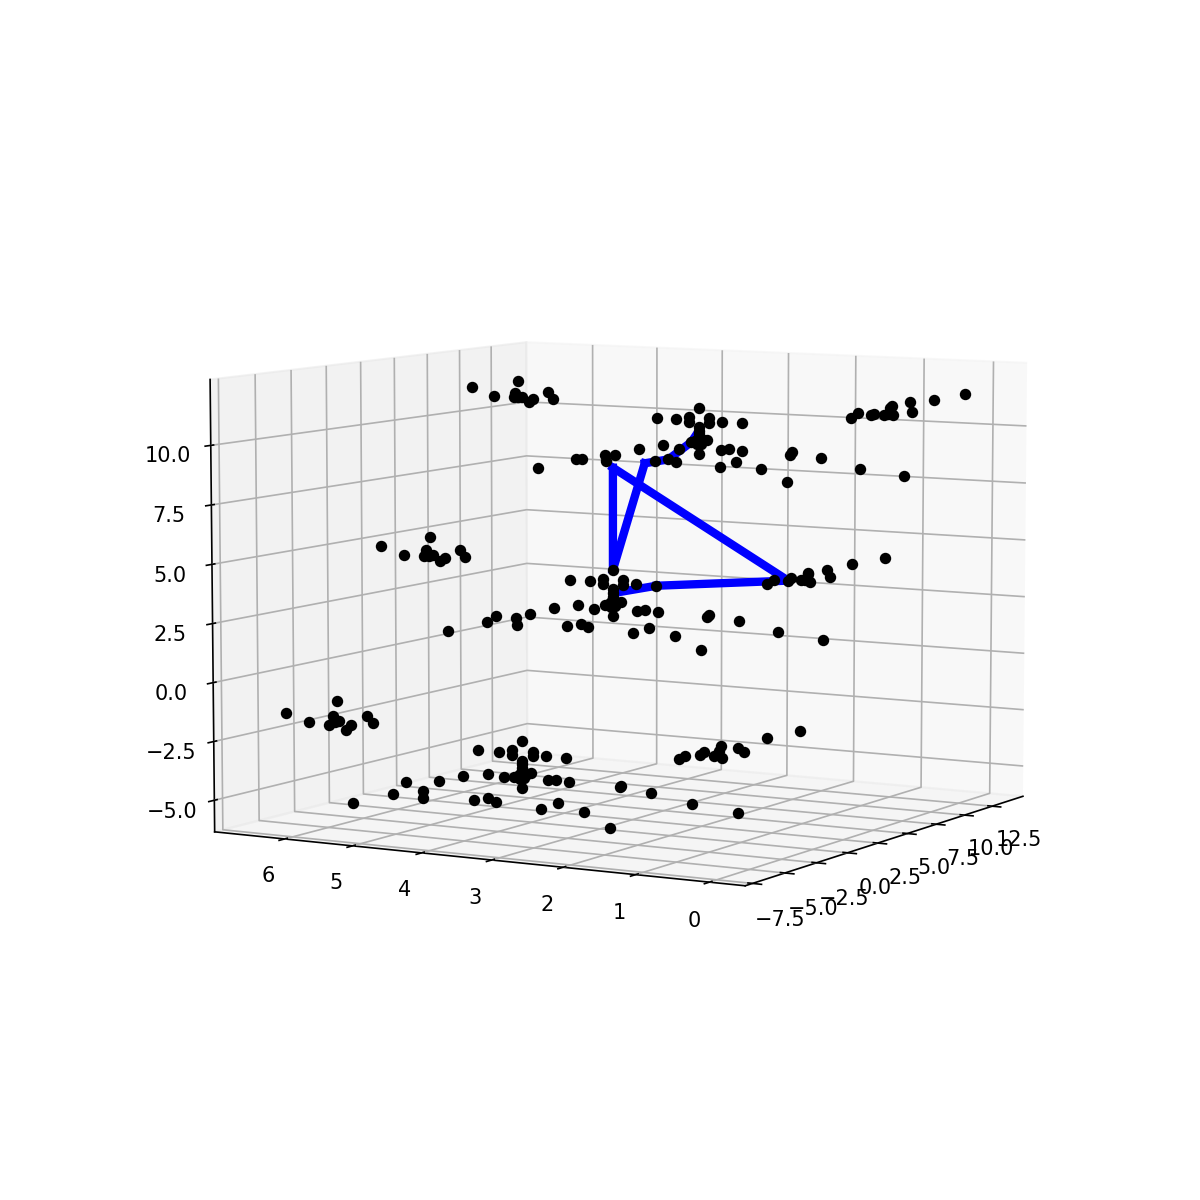

In [542]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

# for node in final.nodes:
#     ax.scatter(final.nodes[node]['coord'][0], final.nodes[node]['coord'][1], final.nodes[node]['coord'][2],
#                color='black')

for node in list(final.nodes)[0:69]:
    ax.scatter(final.nodes[node + key_plus*pos_order['-10-1']]['coord'][0], 
               final.nodes[node + key_plus*pos_order['-10-1']]['coord'][1], 
               final.nodes[node + key_plus*pos_order['-10-1']]['coord'][2],
               color='black')    
    
for node in list(final.nodes)[0:69]:

    ax.scatter(final.nodes[node + key_plus*pos_order['101']]['coord'][0], 
               final.nodes[node + key_plus*pos_order['101']]['coord'][1], 
               final.nodes[node + key_plus*pos_order['101']]['coord'][2],
               color='black')  
    
    
for node in list(final.nodes)[0:69]:

    ax.scatter(final.nodes[node + key_plus*pos_order['000']]['coord'][0], 
               final.nodes[node + key_plus*pos_order['000']]['coord'][1], 
               final.nodes[node + key_plus*pos_order['000']]['coord'][2],
               color='black')  
colors = ['blue', 'green', 'brown', 'black']
k = 0
for ind_path in temp[1:2]:
    
    for i in range(len(ind_path)-1):

        ax.plot([final.nodes[ind_path[i]]['coord'][0], final.nodes[ind_path[i+1]]['coord'][0]], 
                 [final.nodes[ind_path[i]]['coord'][1], final.nodes[ind_path[i+1]]['coord'][1]], 
                zs=[final.nodes[ind_path[i]]['coord'][2], final.nodes[ind_path[i+1]]['coord'][2]],
                linewidth=4, color=colors[k])
    k += 1

In [519]:
temp[0]

[217, 211, 233, 232, 236, 329, 938, 913, 917]

In [520]:
temp[1]

[1617, 1613, 1638, 1029, 936, 1001, 912, 911, 917]

In [476]:
temp

[[217, 211, 233, 232, 236, 329, 938, 913, 917],
 [1617, 1613, 1638, 1029, 936, 1001, 912, 911, 917]]

In [539]:
print(217-210, 211-210,233-210,232-210, 236-210,329-280,938-910,913-910,917-910)
print(1617-1610, 1613-1610,1638-1610,1029-980,936-910,1001-980,912-910,911-910, 917-910)

7 1 23 22 26 49 28 3 7
7 3 28 49 26 21 2 1 7


In [567]:
neigh_dic['911']

[912, 917, 922, 933, 955]

In [535]:
graph_mod['-10-1'][236]

AtlasView({232: {'rad_max_sph': 2.22941}, 272: {'rad_max_sph': 2.22941}, 301: {'rad_max_sph': 1.51934}, 308: {'rad_max_sph': 0.76085}, 329: {'rad_max_sph': 0.76085}})

In [559]:
final[936]

AtlasView({932: {'rad_max_sph': 2.22941, 'distance': 0.4507122161645943}, 972: {'rad_max_sph': 2.22941, 'distance': 0.4507122161645943}, 1001: {'rad_max_sph': 1.51934, 'distance': 4.391120000000001}, 1008: {'rad_max_sph': 0.76085, 'distance': 5.028679974978424}, 1029: {'rad_max_sph': 0.76085, 'distance': 5.028681474601469}})

In [524]:
key_plus

70

In [546]:
final[936]1659

AtlasView({932: {'rad_max_sph': 2.22941, 'distance': 0.4507122161645943}, 972: {'rad_max_sph': 2.22941, 'distance': 0.4507122161645943}, 1001: {'rad_max_sph': 1.51934, 'distance': 4.391120000000001}, 1008: {'rad_max_sph': 0.76085, 'distance': 5.028679974978424}, 1029: {'rad_max_sph': 0.76085, 'distance': 5.028681474601469}})

In [550]:
70*13 000
70*23 101
70*14 001

1610

In [552]:
print(70*13, 70*23, 70*14)

910 1610 980


In [541]:
pos_order

{'-1-1-1': 0,
 '-1-10': 1,
 '-1-11': 2,
 '-10-1': 3,
 '-100': 4,
 '-101': 5,
 '-11-1': 6,
 '-110': 7,
 '-111': 8,
 '0-1-1': 9,
 '0-10': 10,
 '0-11': 11,
 '00-1': 12,
 '000': 13,
 '001': 14,
 '01-1': 15,
 '010': 16,
 '011': 17,
 '1-1-1': 18,
 '1-10': 19,
 '1-11': 20,
 '10-1': 21,
 '100': 22,
 '101': 23,
 '11-1': 24,
 '110': 25,
 '111': 26}